# Regime-based Simulations and Multi-Period Portfolio Models

In this module, we will introduce the concept of economic and market regimes, demonstrate the significance of regime identification, evaluate the performance of regime identification methods

## Table of Contents:
&nbsp;&nbsp;1. [Introduction to Economic Regimes](#1)

&nbsp;&nbsp;2. [Identification of Regimes: the Trend-Filtering Algorithm](#2)   

&nbsp;&nbsp;3. [A Regime-based Single Period Model](#3)   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 [Regime Identification: Parameter Estimation](#3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Scenario Simulation](#3.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Single-period Portfolio Model](#3.3)

&nbsp;&nbsp;4. [Application: Scenario-based Analysis of University Endowment](#4) 

## 1. Introduction to Economic Regimes <a class="anchor" id="1"></a>

A regime is a period of time in which the characteristics of market performance and related economic activity are reasonably stable. 

For better analysis of the market, we would like to catagorize historical periods into a small number of regimes and evaluate each regime separately.

Let us plot the historical performance of the US stock market index (S&P 500) with regimes that we have determined. You will learn how to determine the regimes later in this chapter, so hang tight with us.

In [1]:
# import all the necessary packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns

from regime_model_lib import *

sns.set()
register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [2]:
# To import data successfully, change the folder to the directory of your data
file_path = 'Assets_7.csv'
asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])
asset_data.head()
# What do Regime-5,7,9 mean?
# We use SP500 index to calibrate the regimes
# regime-5: lambda = 16
# regime-7: lambda = 14
# regime-9: lambda = 10
# 1 for growth regime
# -1 for contraction

C:\Users\Jason\AppData\Local\Temp\ipykernel_8308\2106406431.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])
C:\Users\Jason\AppData\Local\Temp\ipykernel_8308\2106406431.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])


,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-01-01,3.69,443.231,100.0000,112.905,382.65,769.53,245.62,564.0916,0.30%,1,1,1
1985-02-01,3.99,455.868,101.9243,117.185,404.31,785.96,252.75,567.9944,-1.12%,1,1,1
1985-03-01,4.11,451.672,100.1330,118.672,410.96,774.00,246.33,571.6528,1.61%,1,1,1
1985-04-01,4.08,485.608,102.0311,119.185,408.20,802.77,251.11,575.8523,2.37%,1,1,1
1985-05-01,4.03,484.414,104.1377,121.356,408.57,774.58,256.72,579.6807,5.26%,1,1,1


Text(0.5, 0, 'Year')

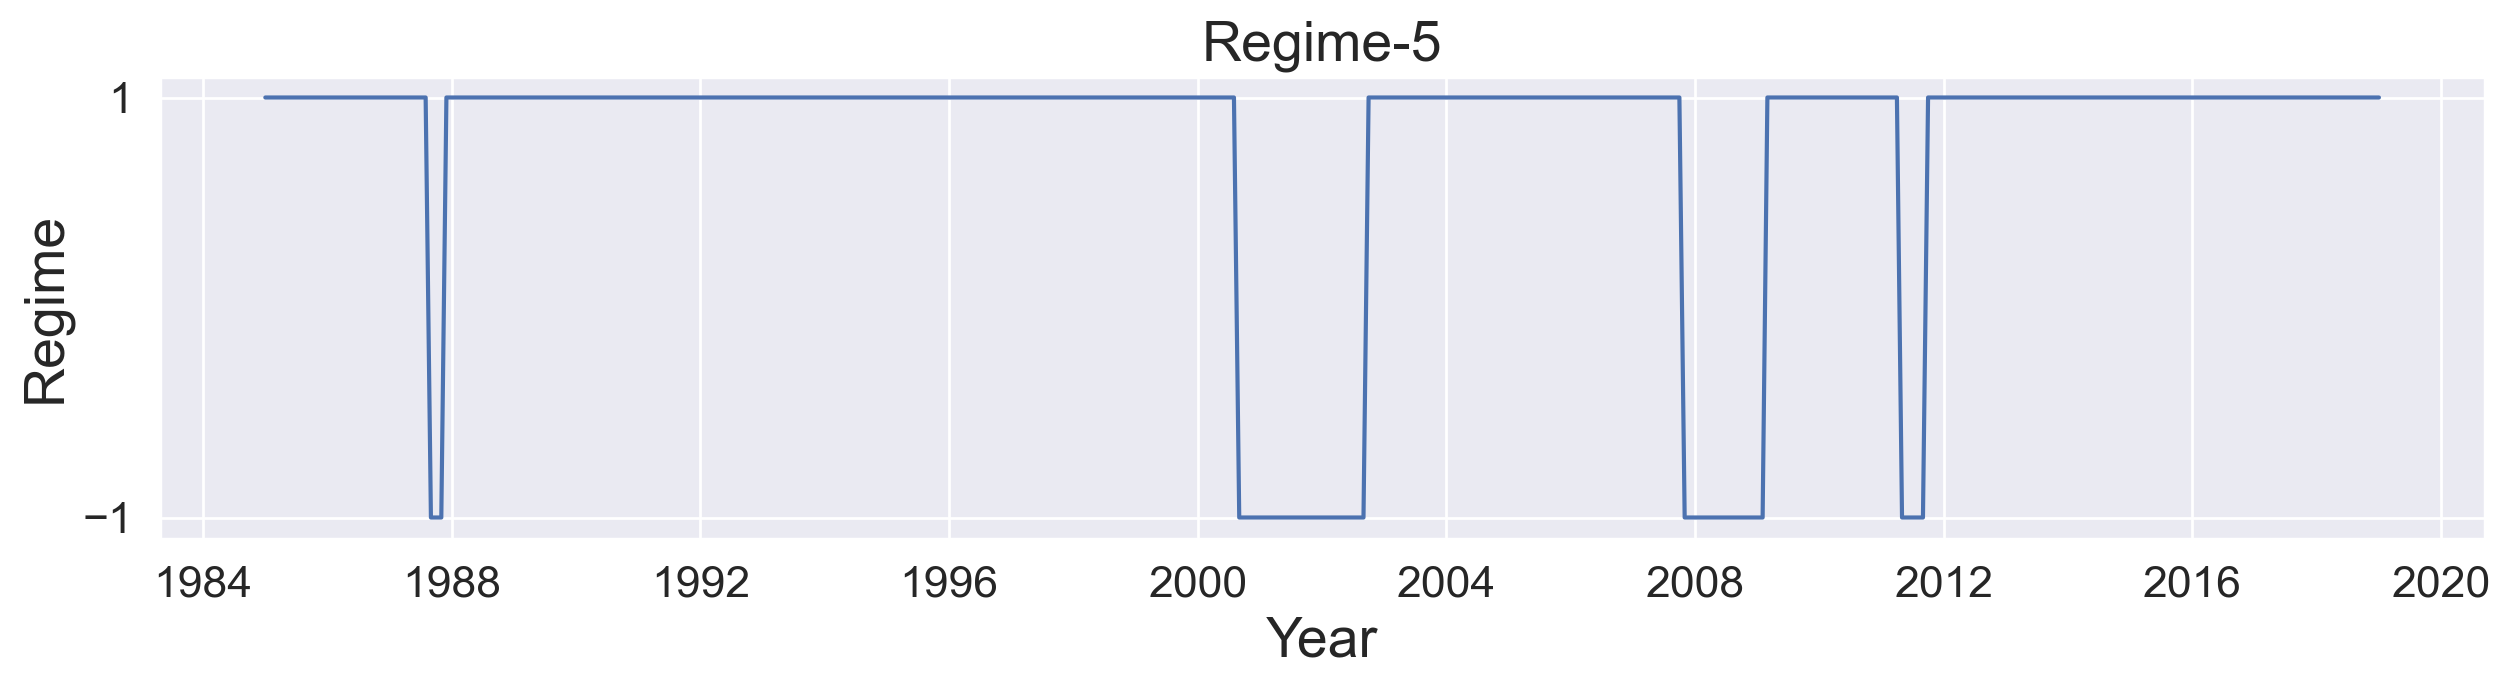

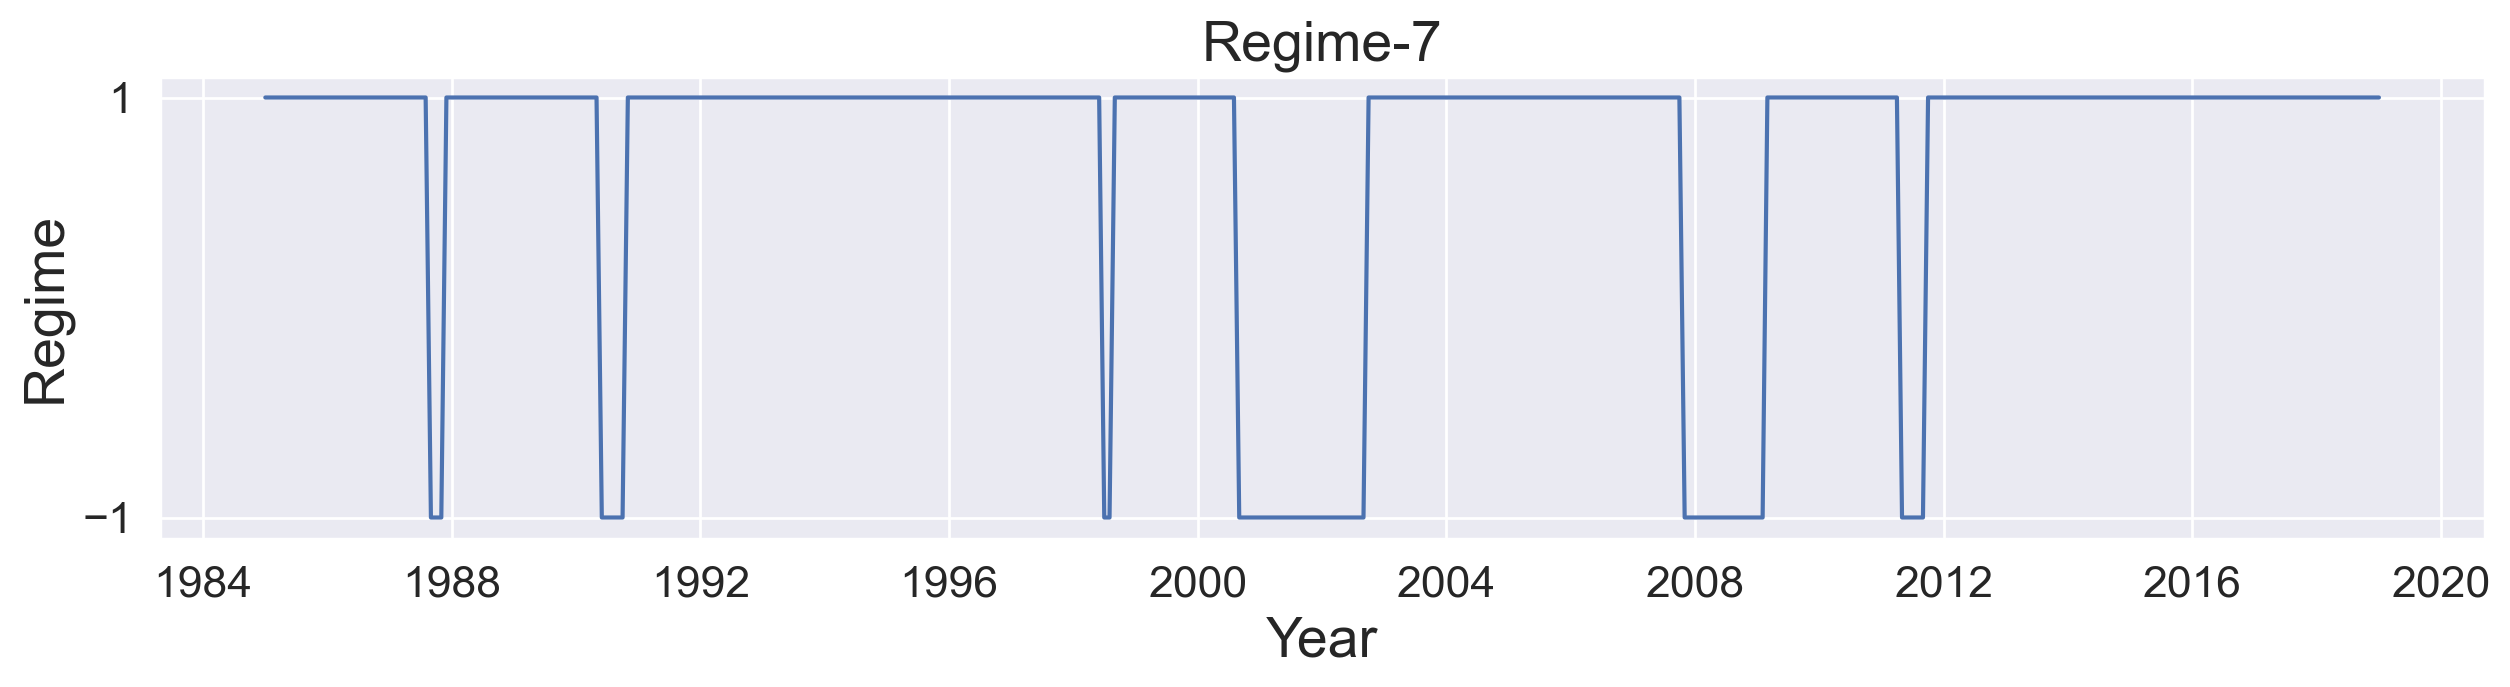

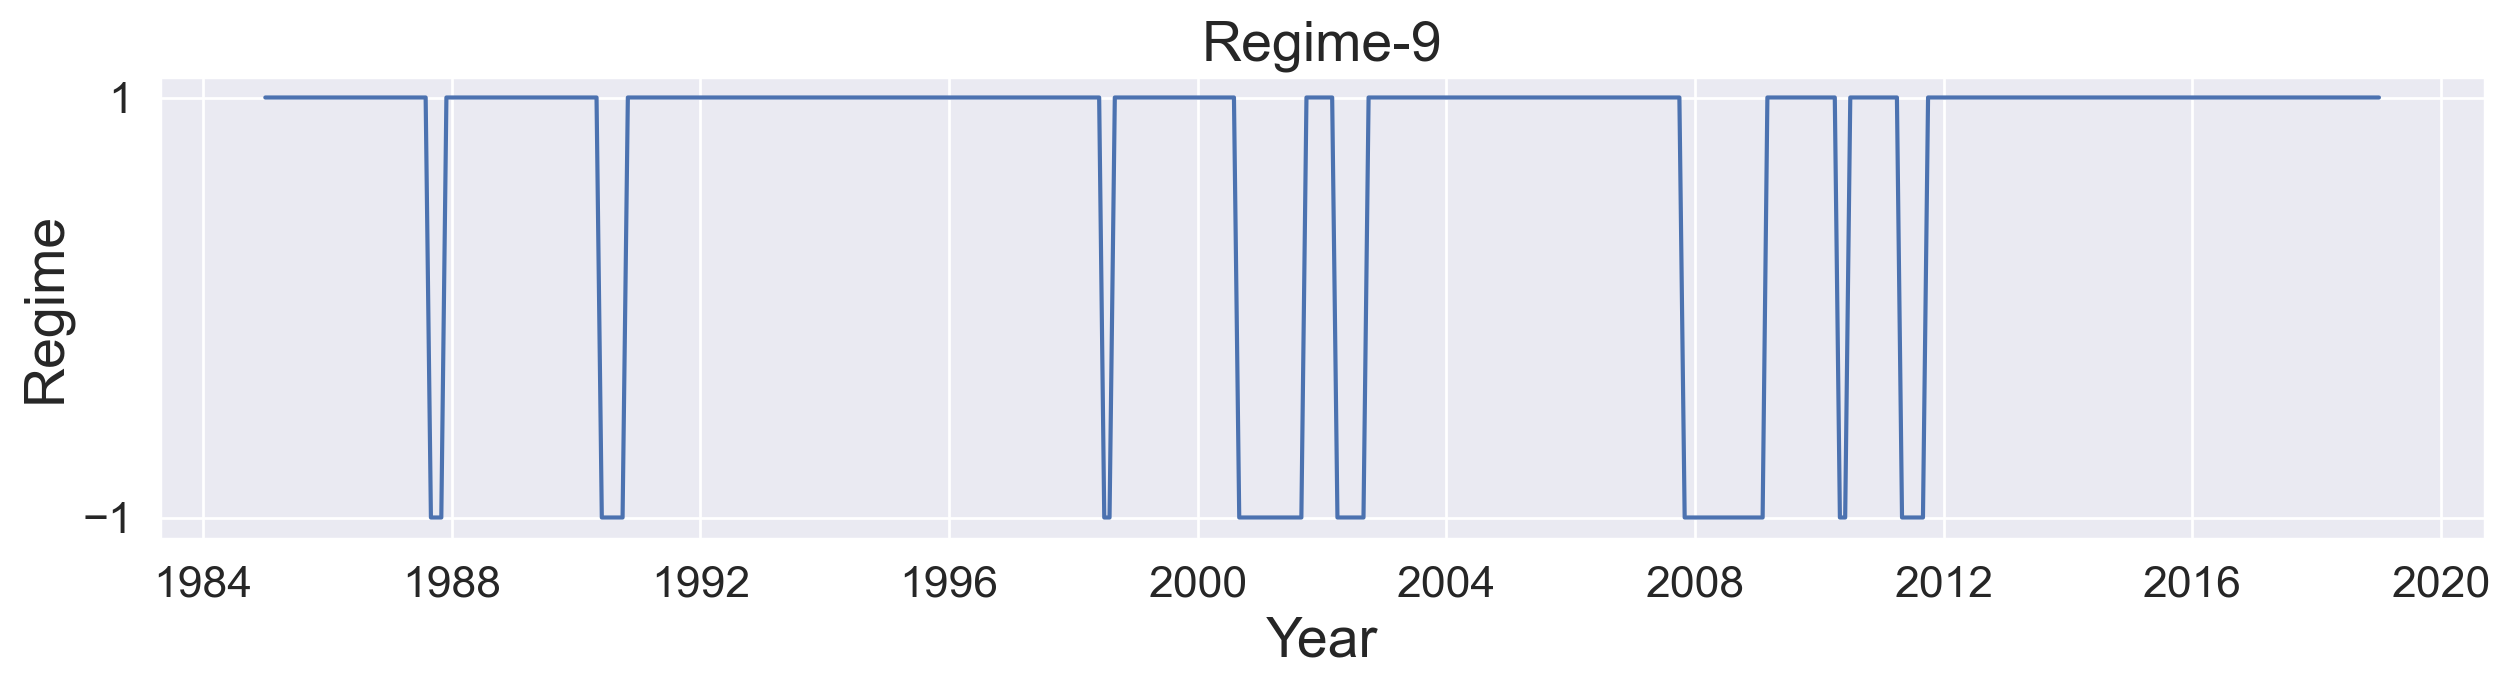

In [3]:
# Plot regimes. The method to generate this series will be shown in the section below
plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-5'])
plt.title('Regime-5',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-7'])
plt.title('Regime-7',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-9'])
plt.title('Regime-9',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

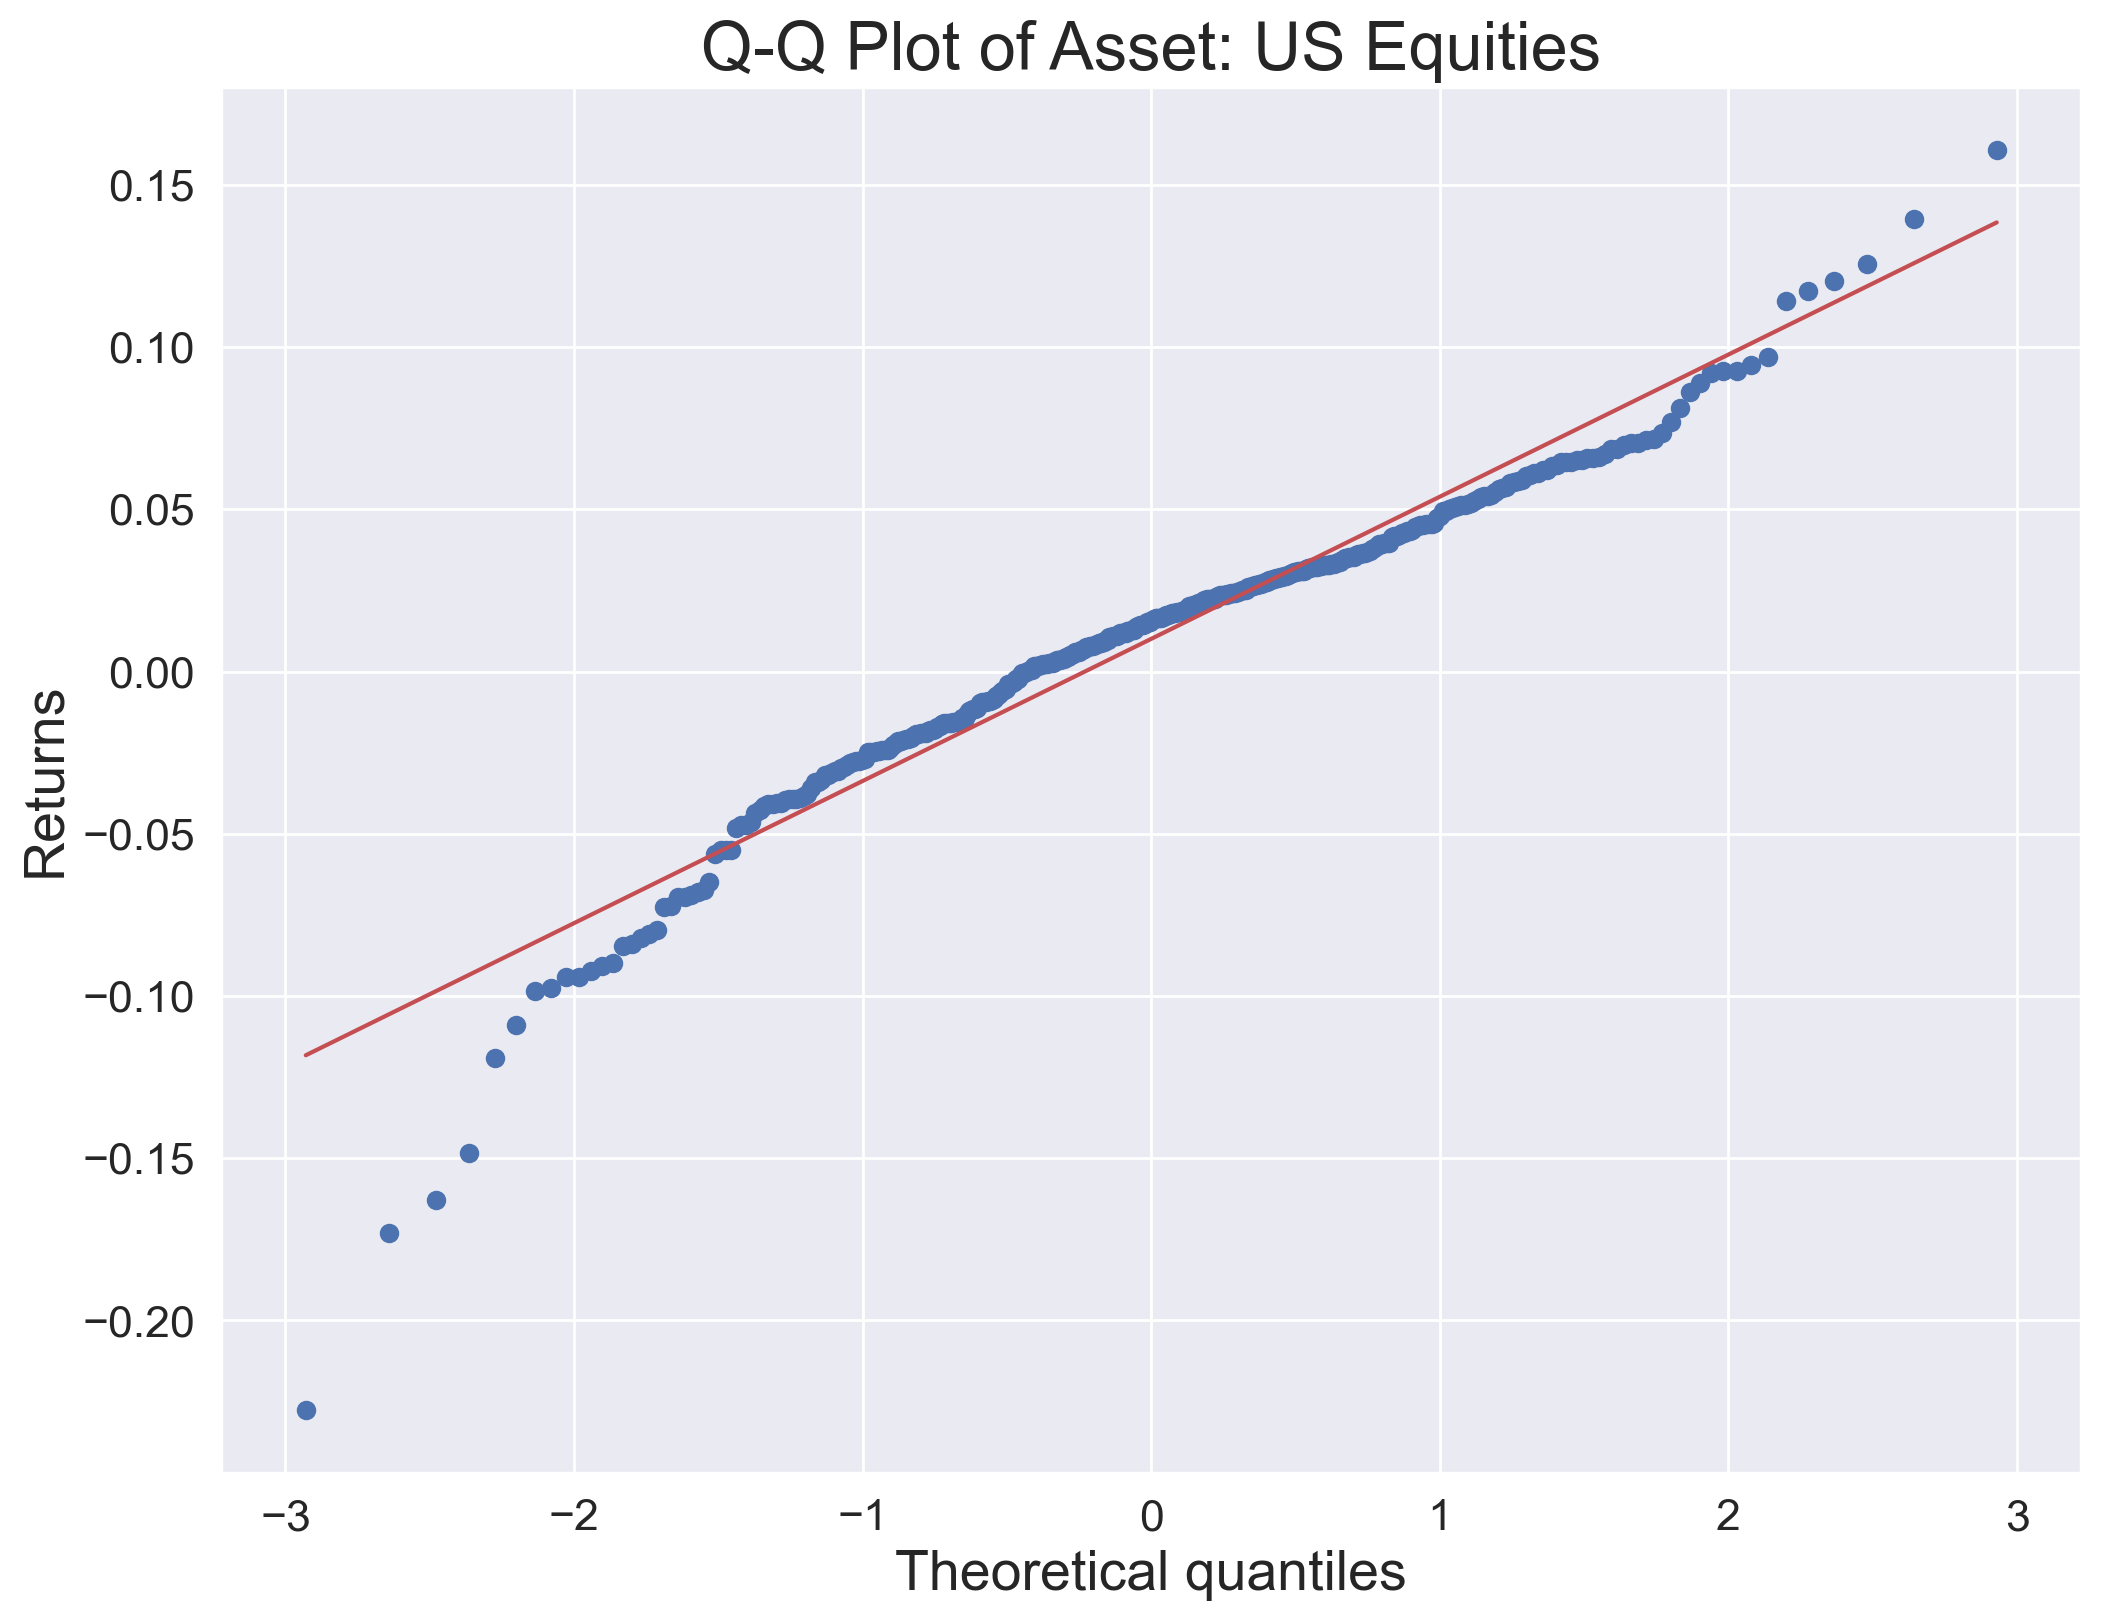

In [4]:
asset_index = [0,1,2,3,4,5,6,7]
# asset_return: total return
# ret_g: return during growth regime
# ret_c: return during contraction regime
ret, ret_g, ret_c = regime_return(asset_data, asset_index, 'Regime-5')

Q_Q_plot(asset_data, 0, ret, ret_g, ret_c)
# fat tail on the left

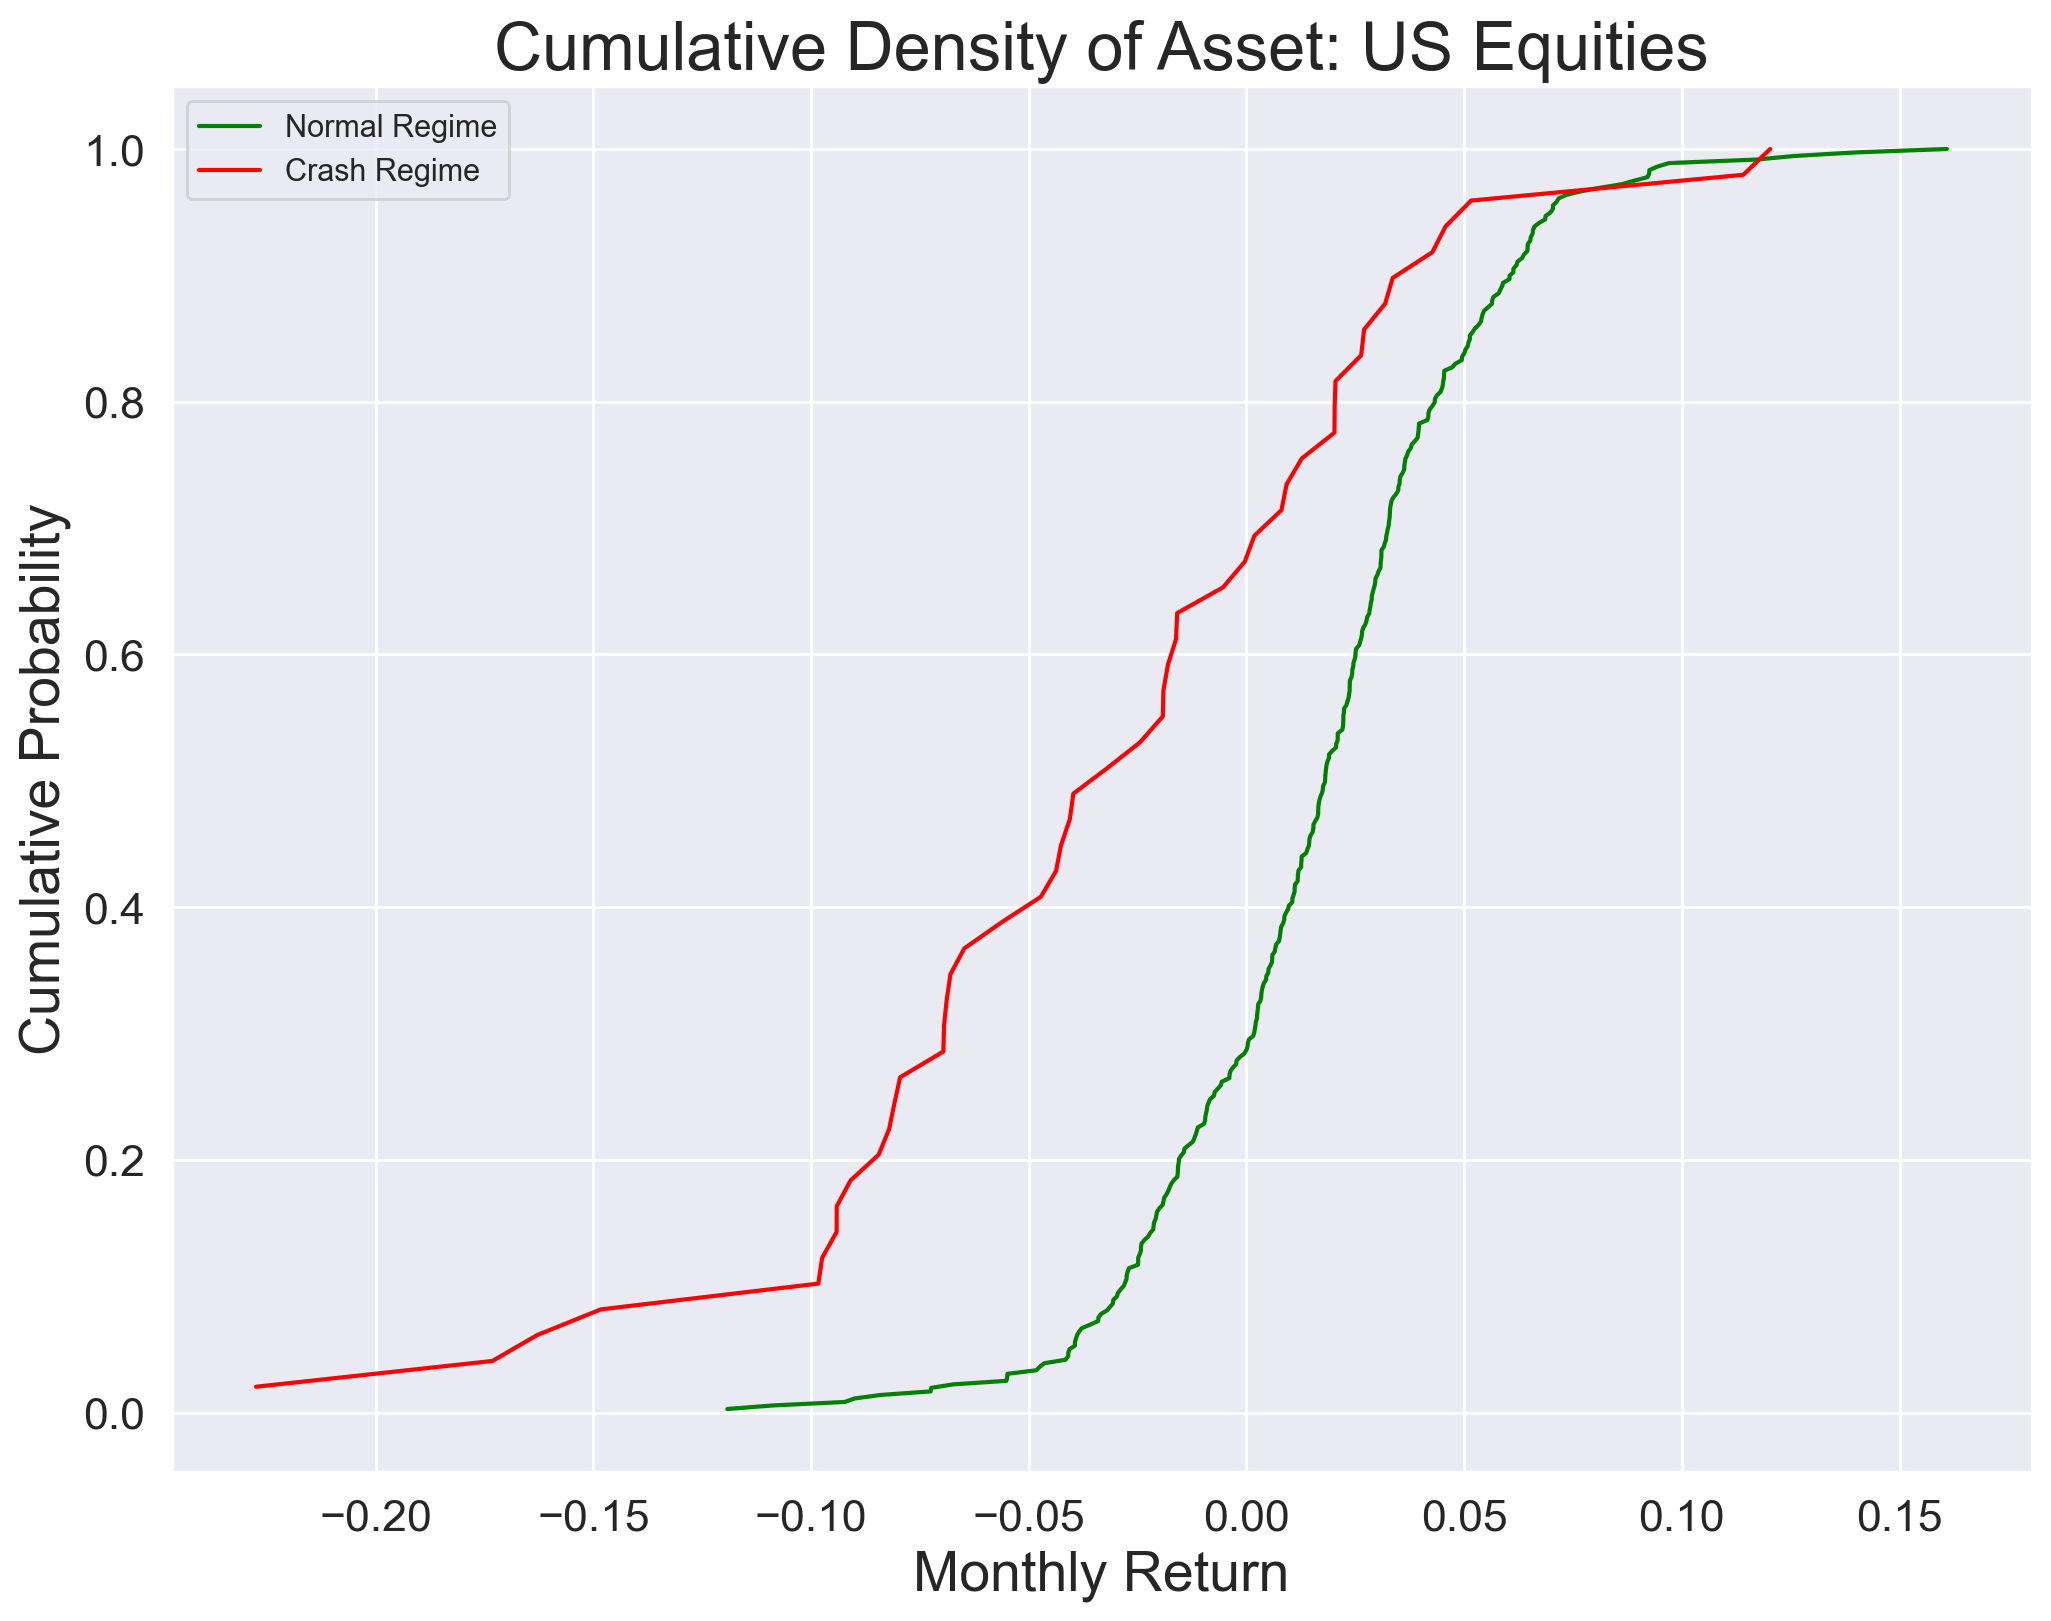

In [5]:
regime_plot(asset_data, 0, ret, ret_g, ret_c)

We can observe that the monthly return distribution of World Equities is very different under growth regime or contraction regime. 

## 2. Identification of Regimes <a class="anchor" id="2"></a>

A regime analysis is significant in asset allocation and asset-liability management for long-term investors because of the contagion and related effects during crash periods: the correlation between risky assets and volatility will greatly increase during the crash periods, thus creating severe difficulty in risk management and protecting investor capital with traditional portfolio models.


Many existing methods are based on econometric models which assume a fixed structural model. However, financial return or macroeconomic data tends to be noisy and affected by myriad of factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), trend-filtering, is non-parametric, data-driven and model-free. The algorithm was first introduced by Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [6]:
# Import Data
file_path = 'SP500.csv'

SP500_data = pd.read_csv(file_path, index_col=0, header=0, parse_dates=[0])
SP500_data.head()

C:\Users\Jason\AppData\Local\Temp\ipykernel_8308\983953190.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  SP500_data = pd.read_csv(file_path, index_col=0, header=0, parse_dates=[0])


,SP500,SP500TR
DATE,,
1985-01-01,0.5585,84.7932
1985-02-01,7.4747,91.1312
1985-03-01,5.5791,96.2155
1985-04-01,-1.1260,95.1321
1985-05-01,5.3201,100.1932


In the trend-filtering algorithm, we manage to find some ‘fitted’ time series that serves as the signal of the trend. This new time series can be obtained by solving the following optimizationproblem:

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

where

\begin{equation*} 
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
\end{equation*}

Let's take a look at our $\beta$ values versus the original SP500 total returns:

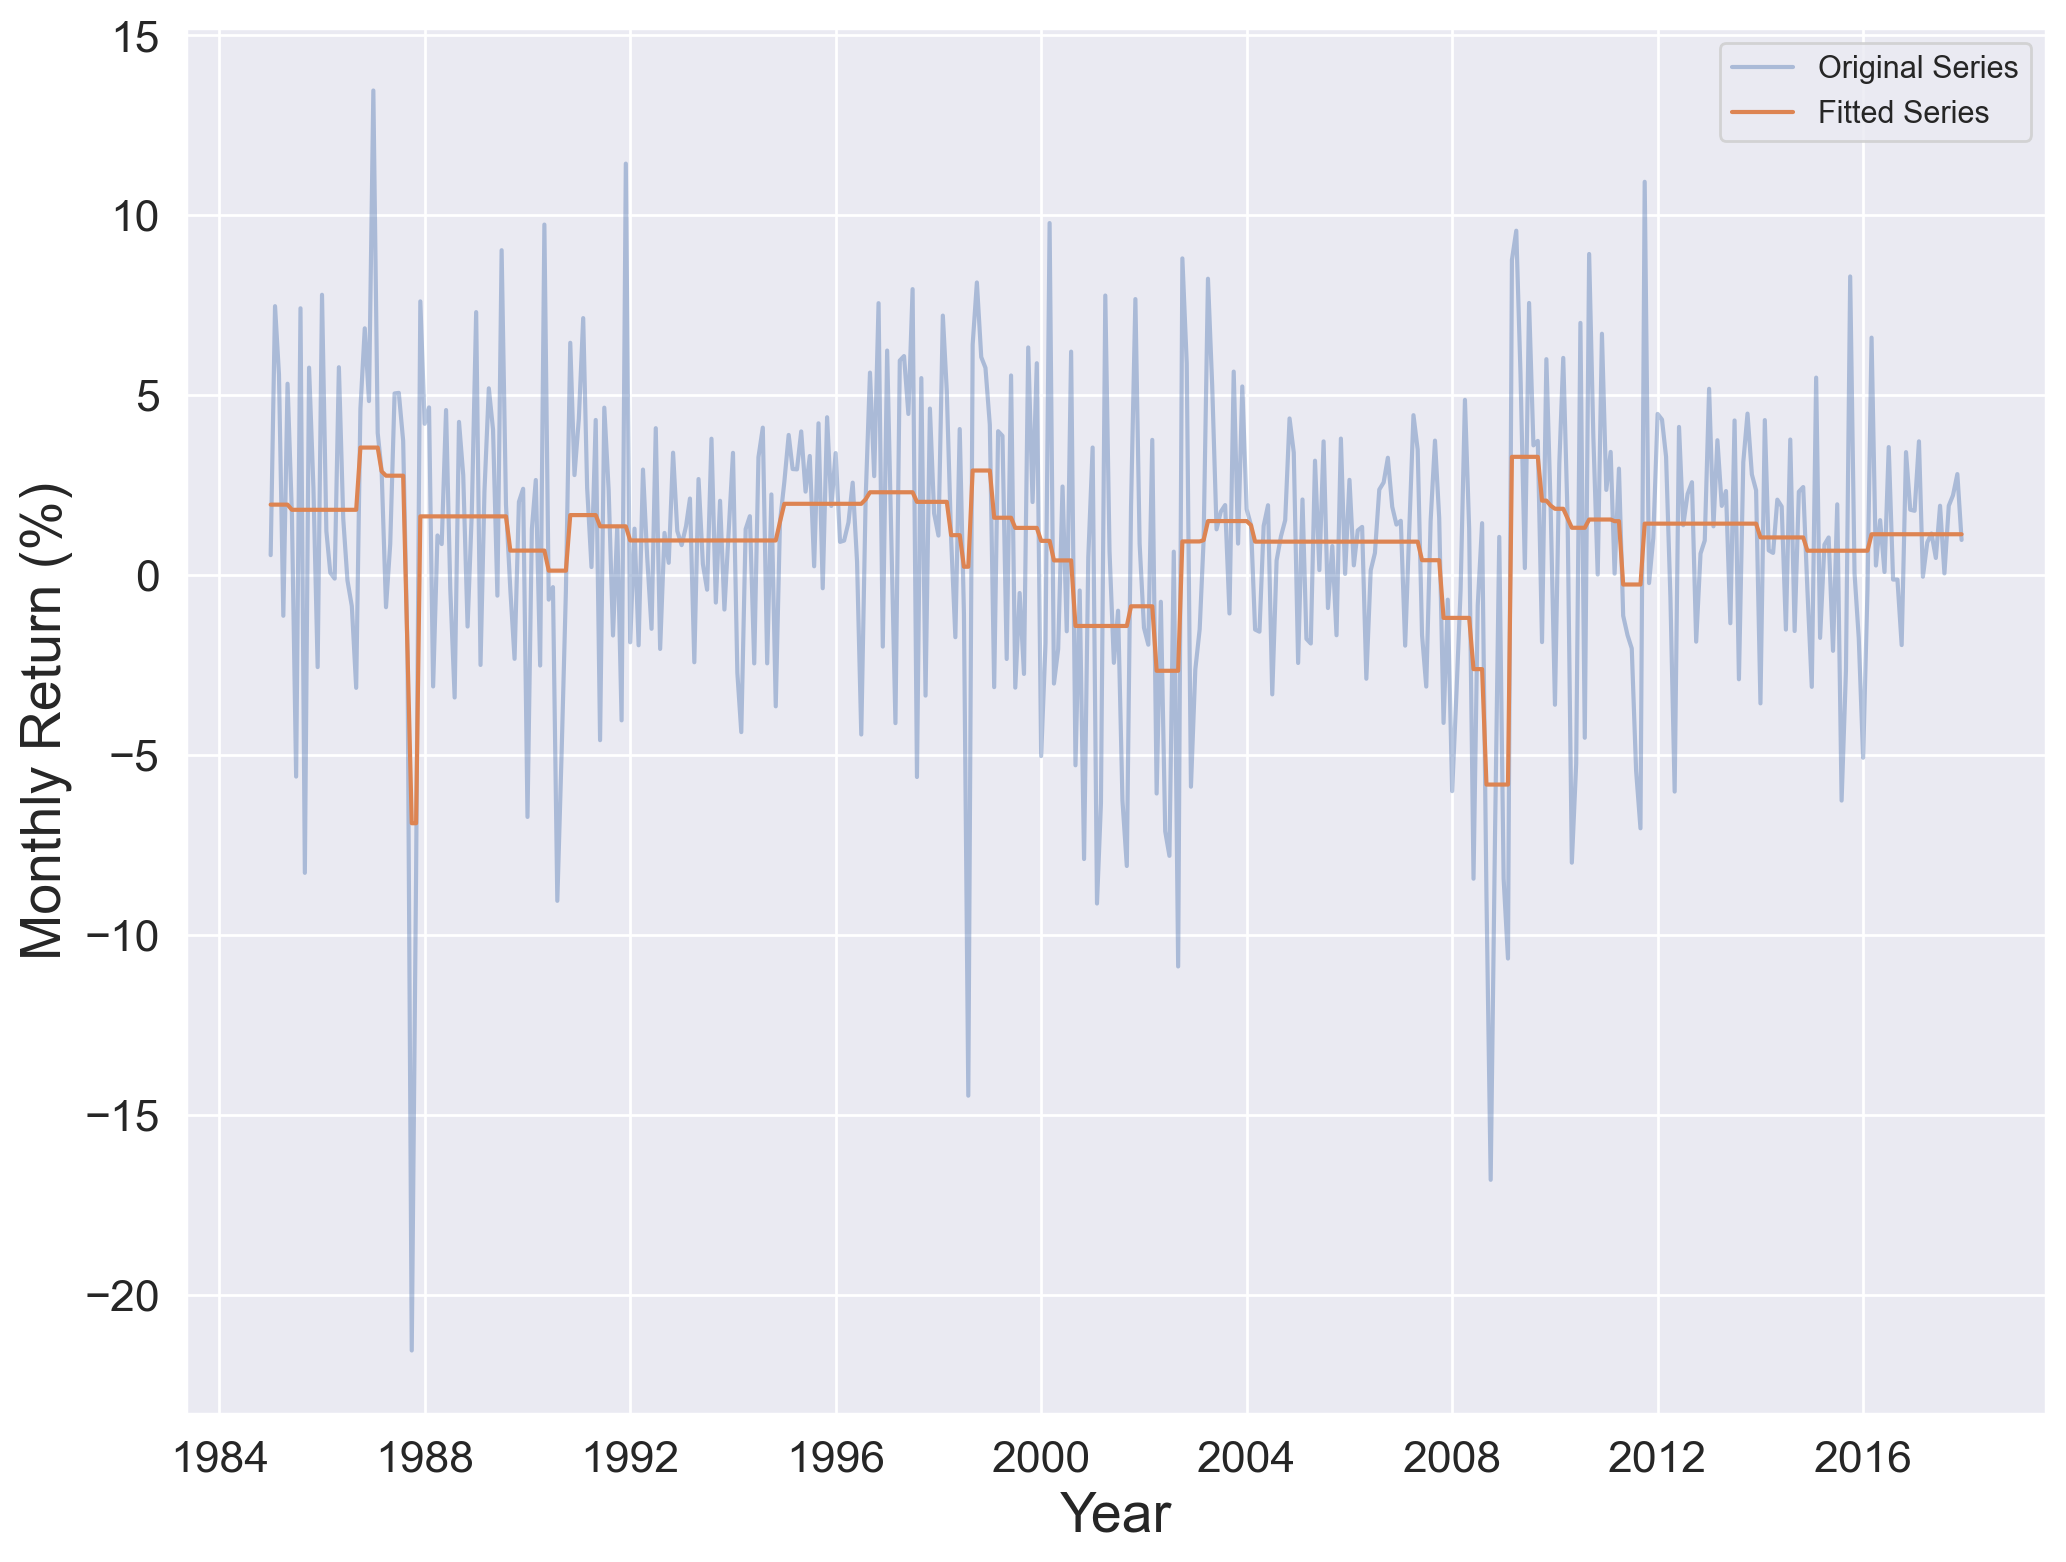

In [7]:
# The blue line is the original data, noisy
# The red line is the estimated trend line via trend filtering
filter_plot(SP500_data, lambda_value=16)

The selection of $\lambda$ can be done with people's knowledge. We can plot the regimes with different $\lambda$ and choose the best one. Empirically, there will be fewer regimes with larger $\lambda$ because it prevent $\beta$ from changing, and vice versa. We need to make a balance and avoid both too sparse or too dense regime changes.

In [8]:
# Generate the regime series as we have shown above
df_regime = pd.DataFrame()
df_regime['Regime-5'] = get_regime_series(SP500_data, lambda_value=16)
df_regime['Regime-7'] = get_regime_series(SP500_data, lambda_value=14)
df_regime['Regime-9'] = get_regime_series(SP500_data, lambda_value=10)
df_regime.head()

c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,Regime-5,Regime-7,Regime-9
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


Text(0, 0.5, 'Regime')

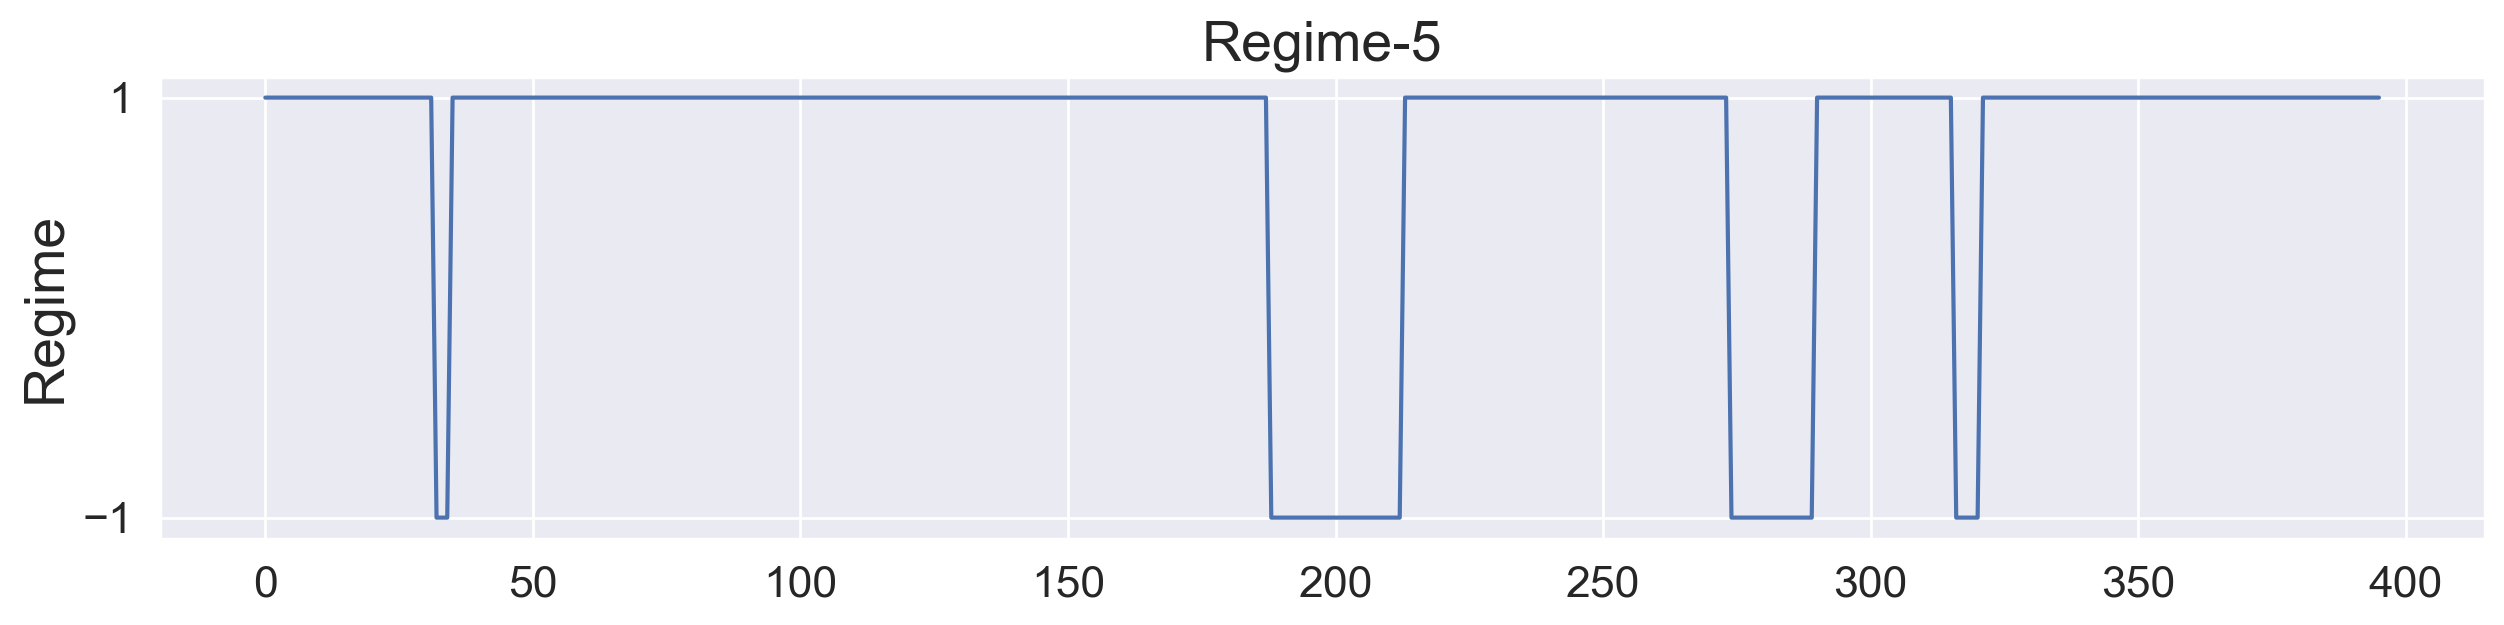

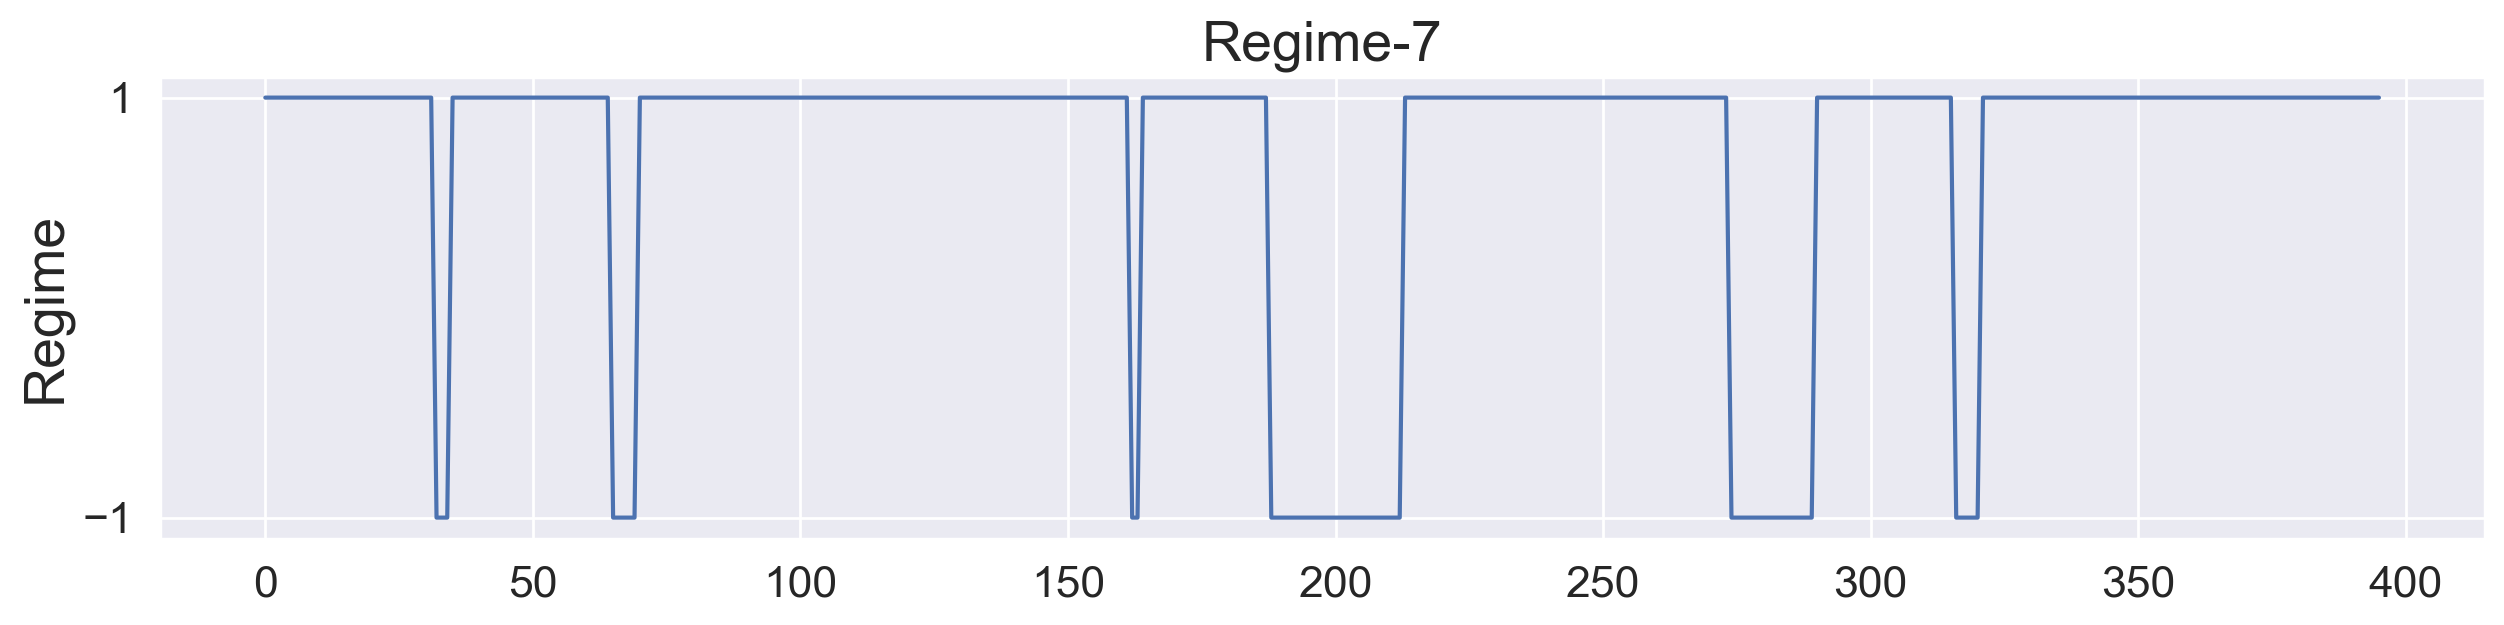

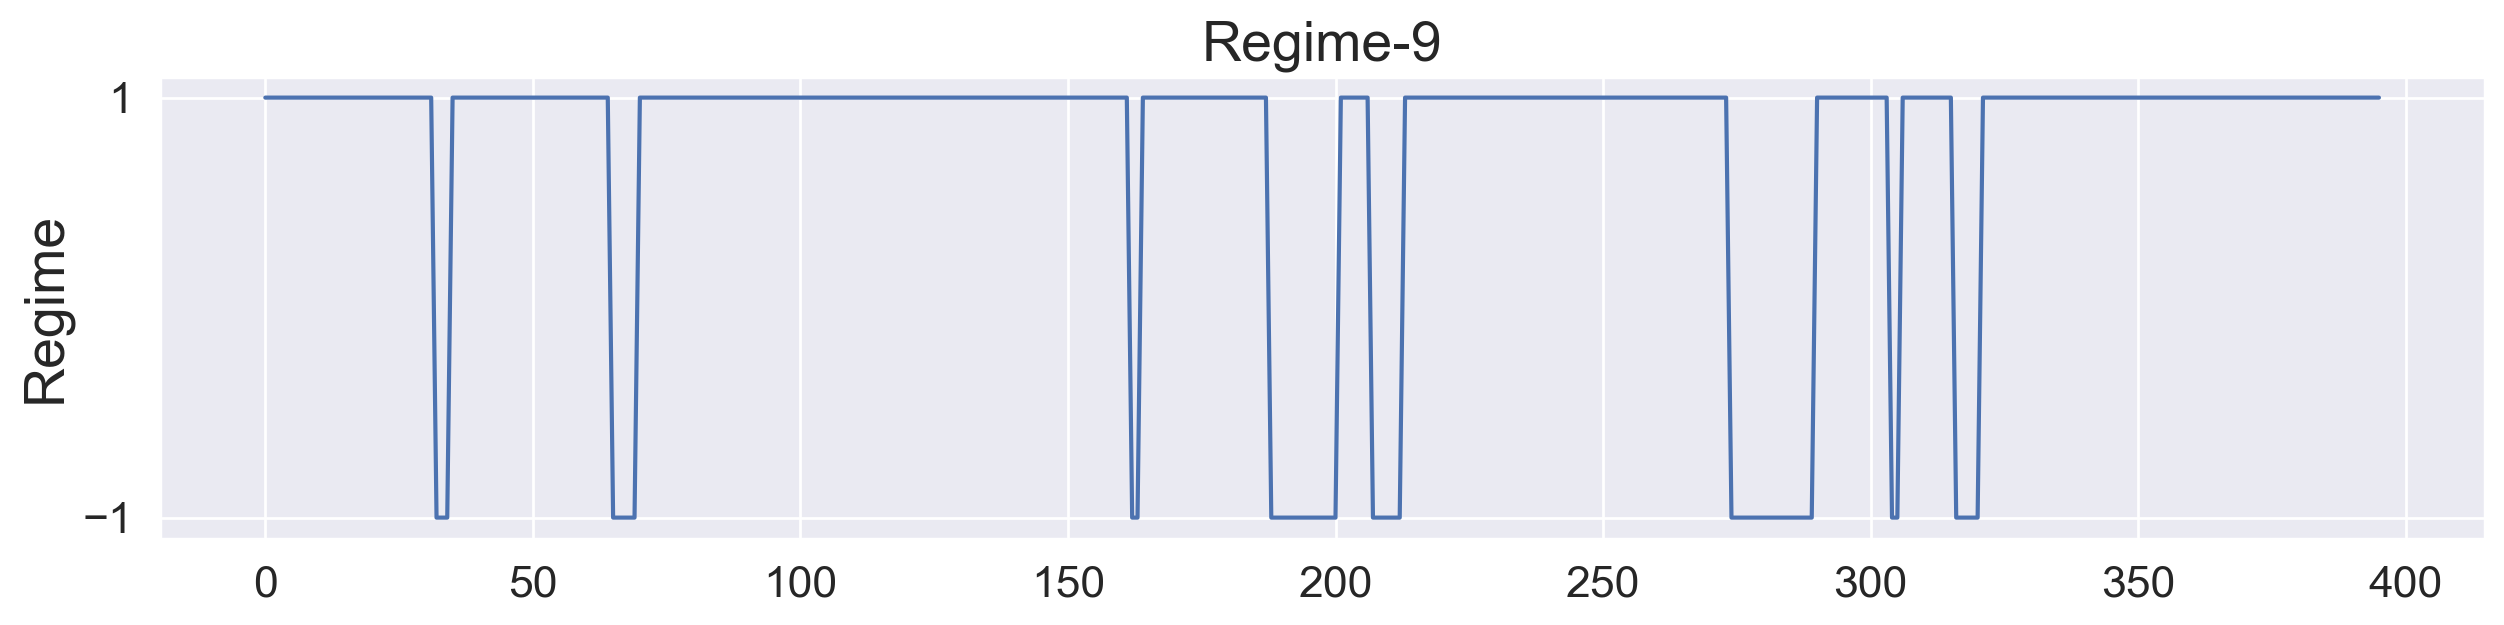

In [9]:
# Plot the regime series
plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-5'])
plt.title('Regime-5',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-7'])
plt.title('Regime-7',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-9'])
plt.title('Regime-9',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

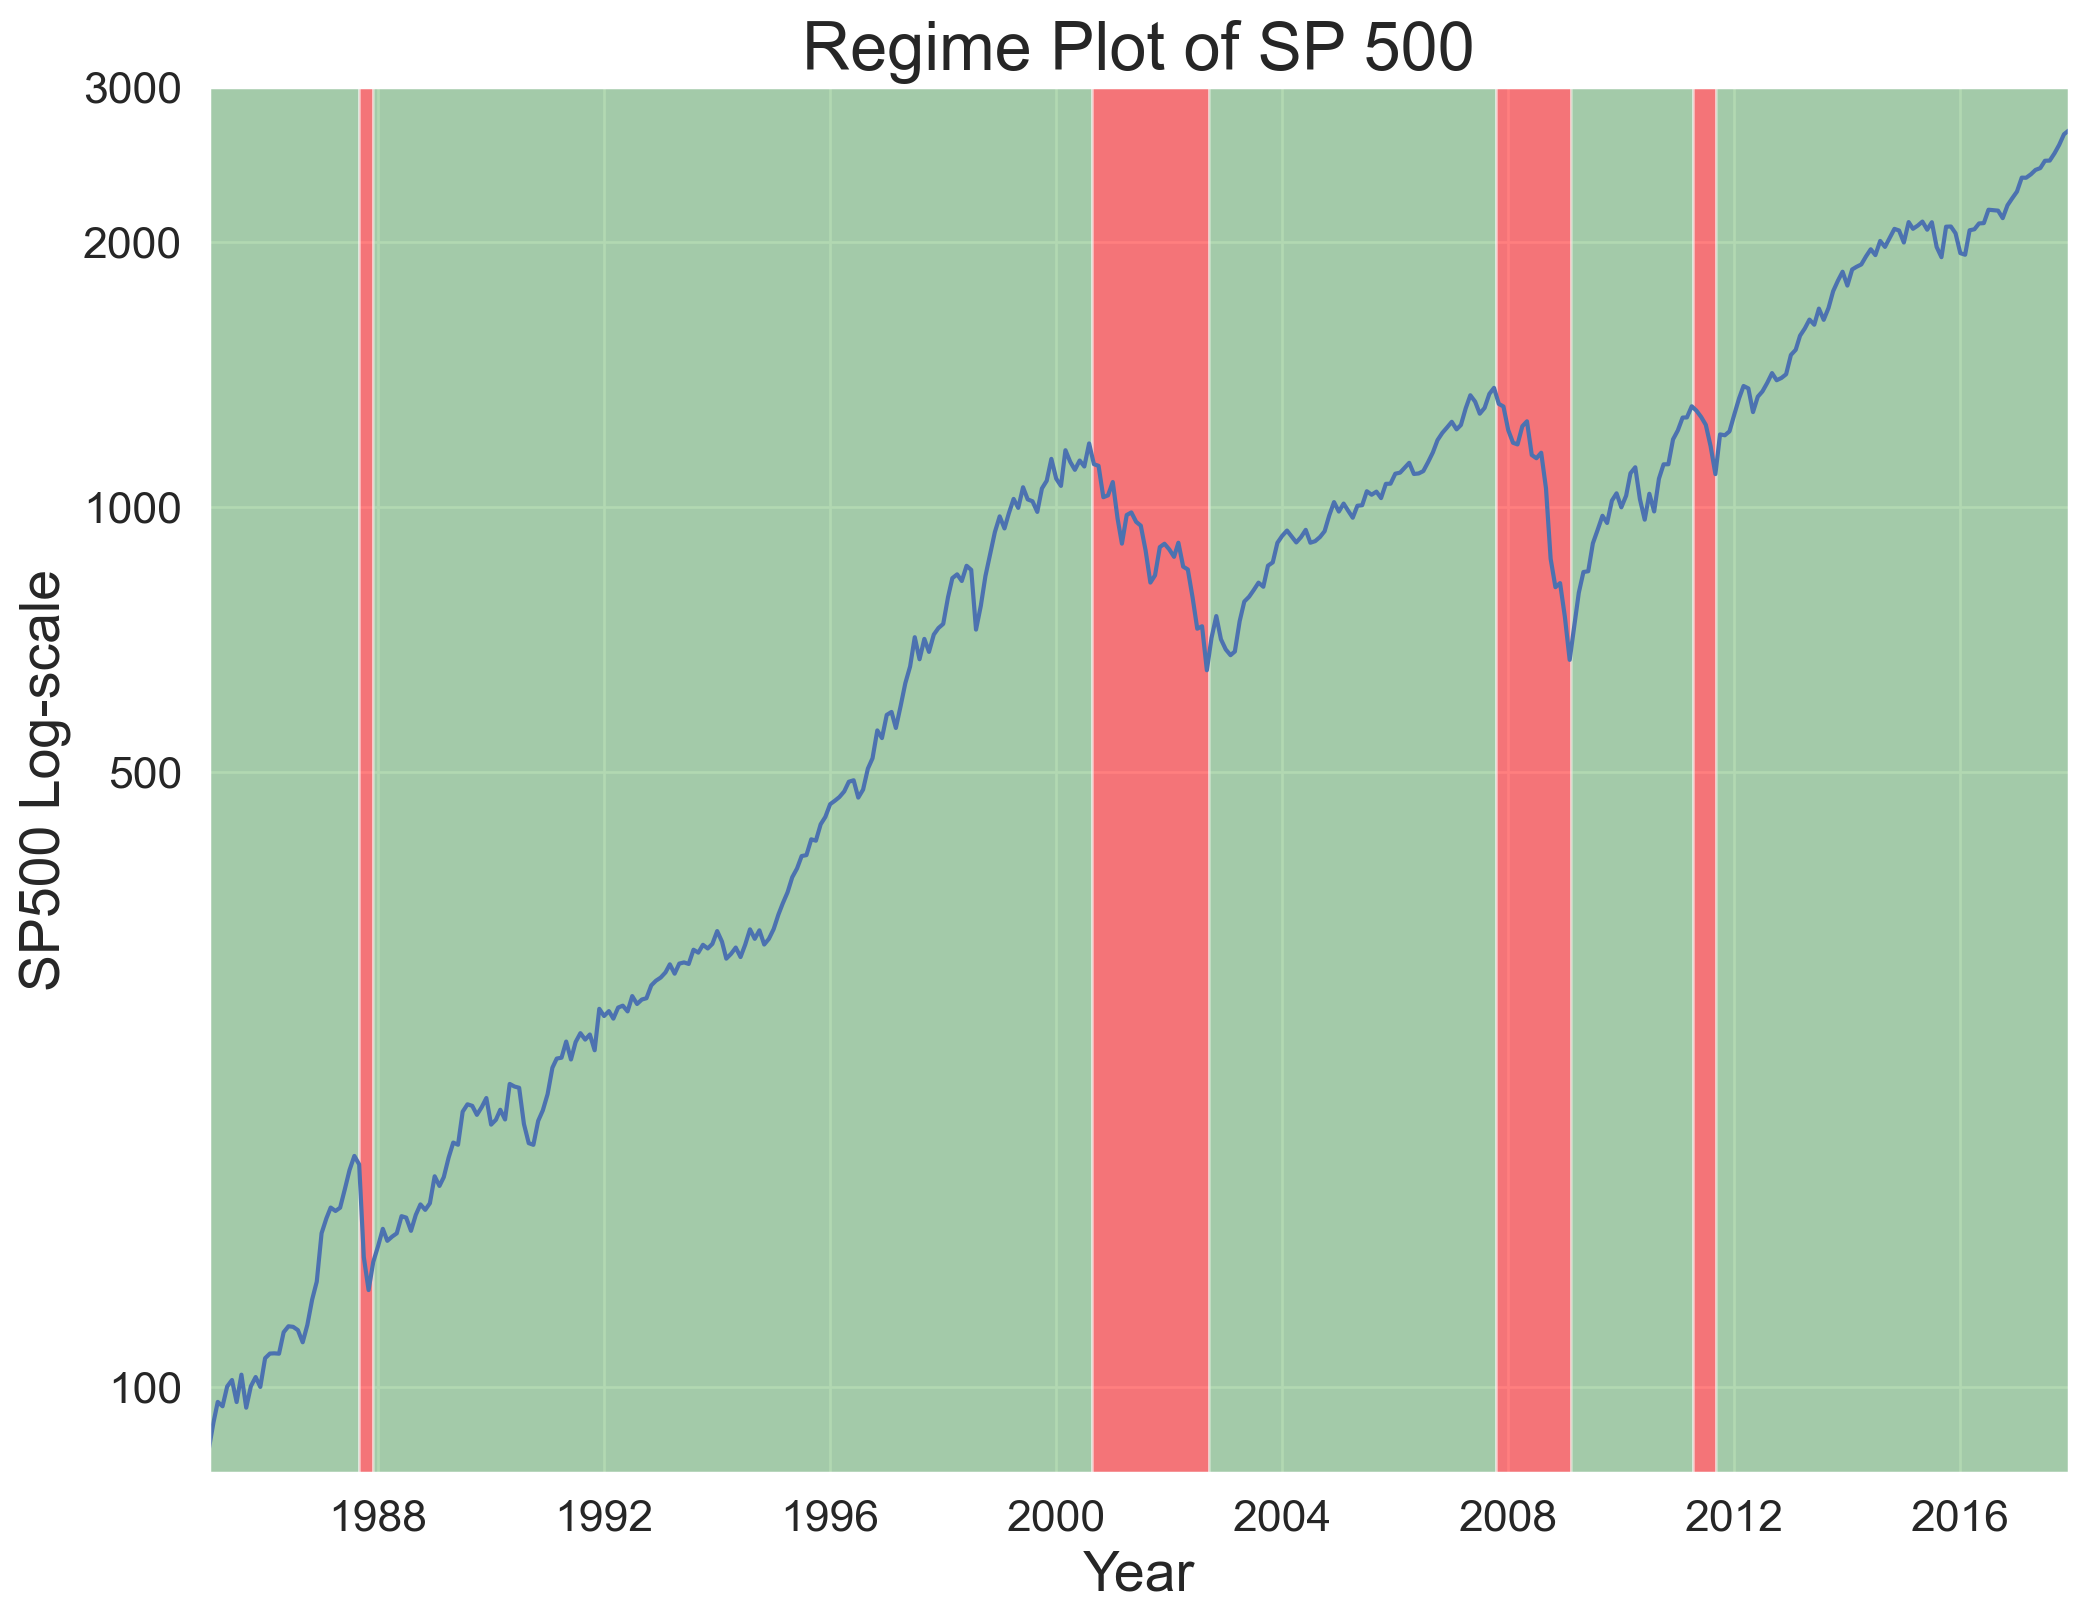

In [10]:
plot_regime_color(SP500_data, lambda_value=16)
# 4 crash periods

c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


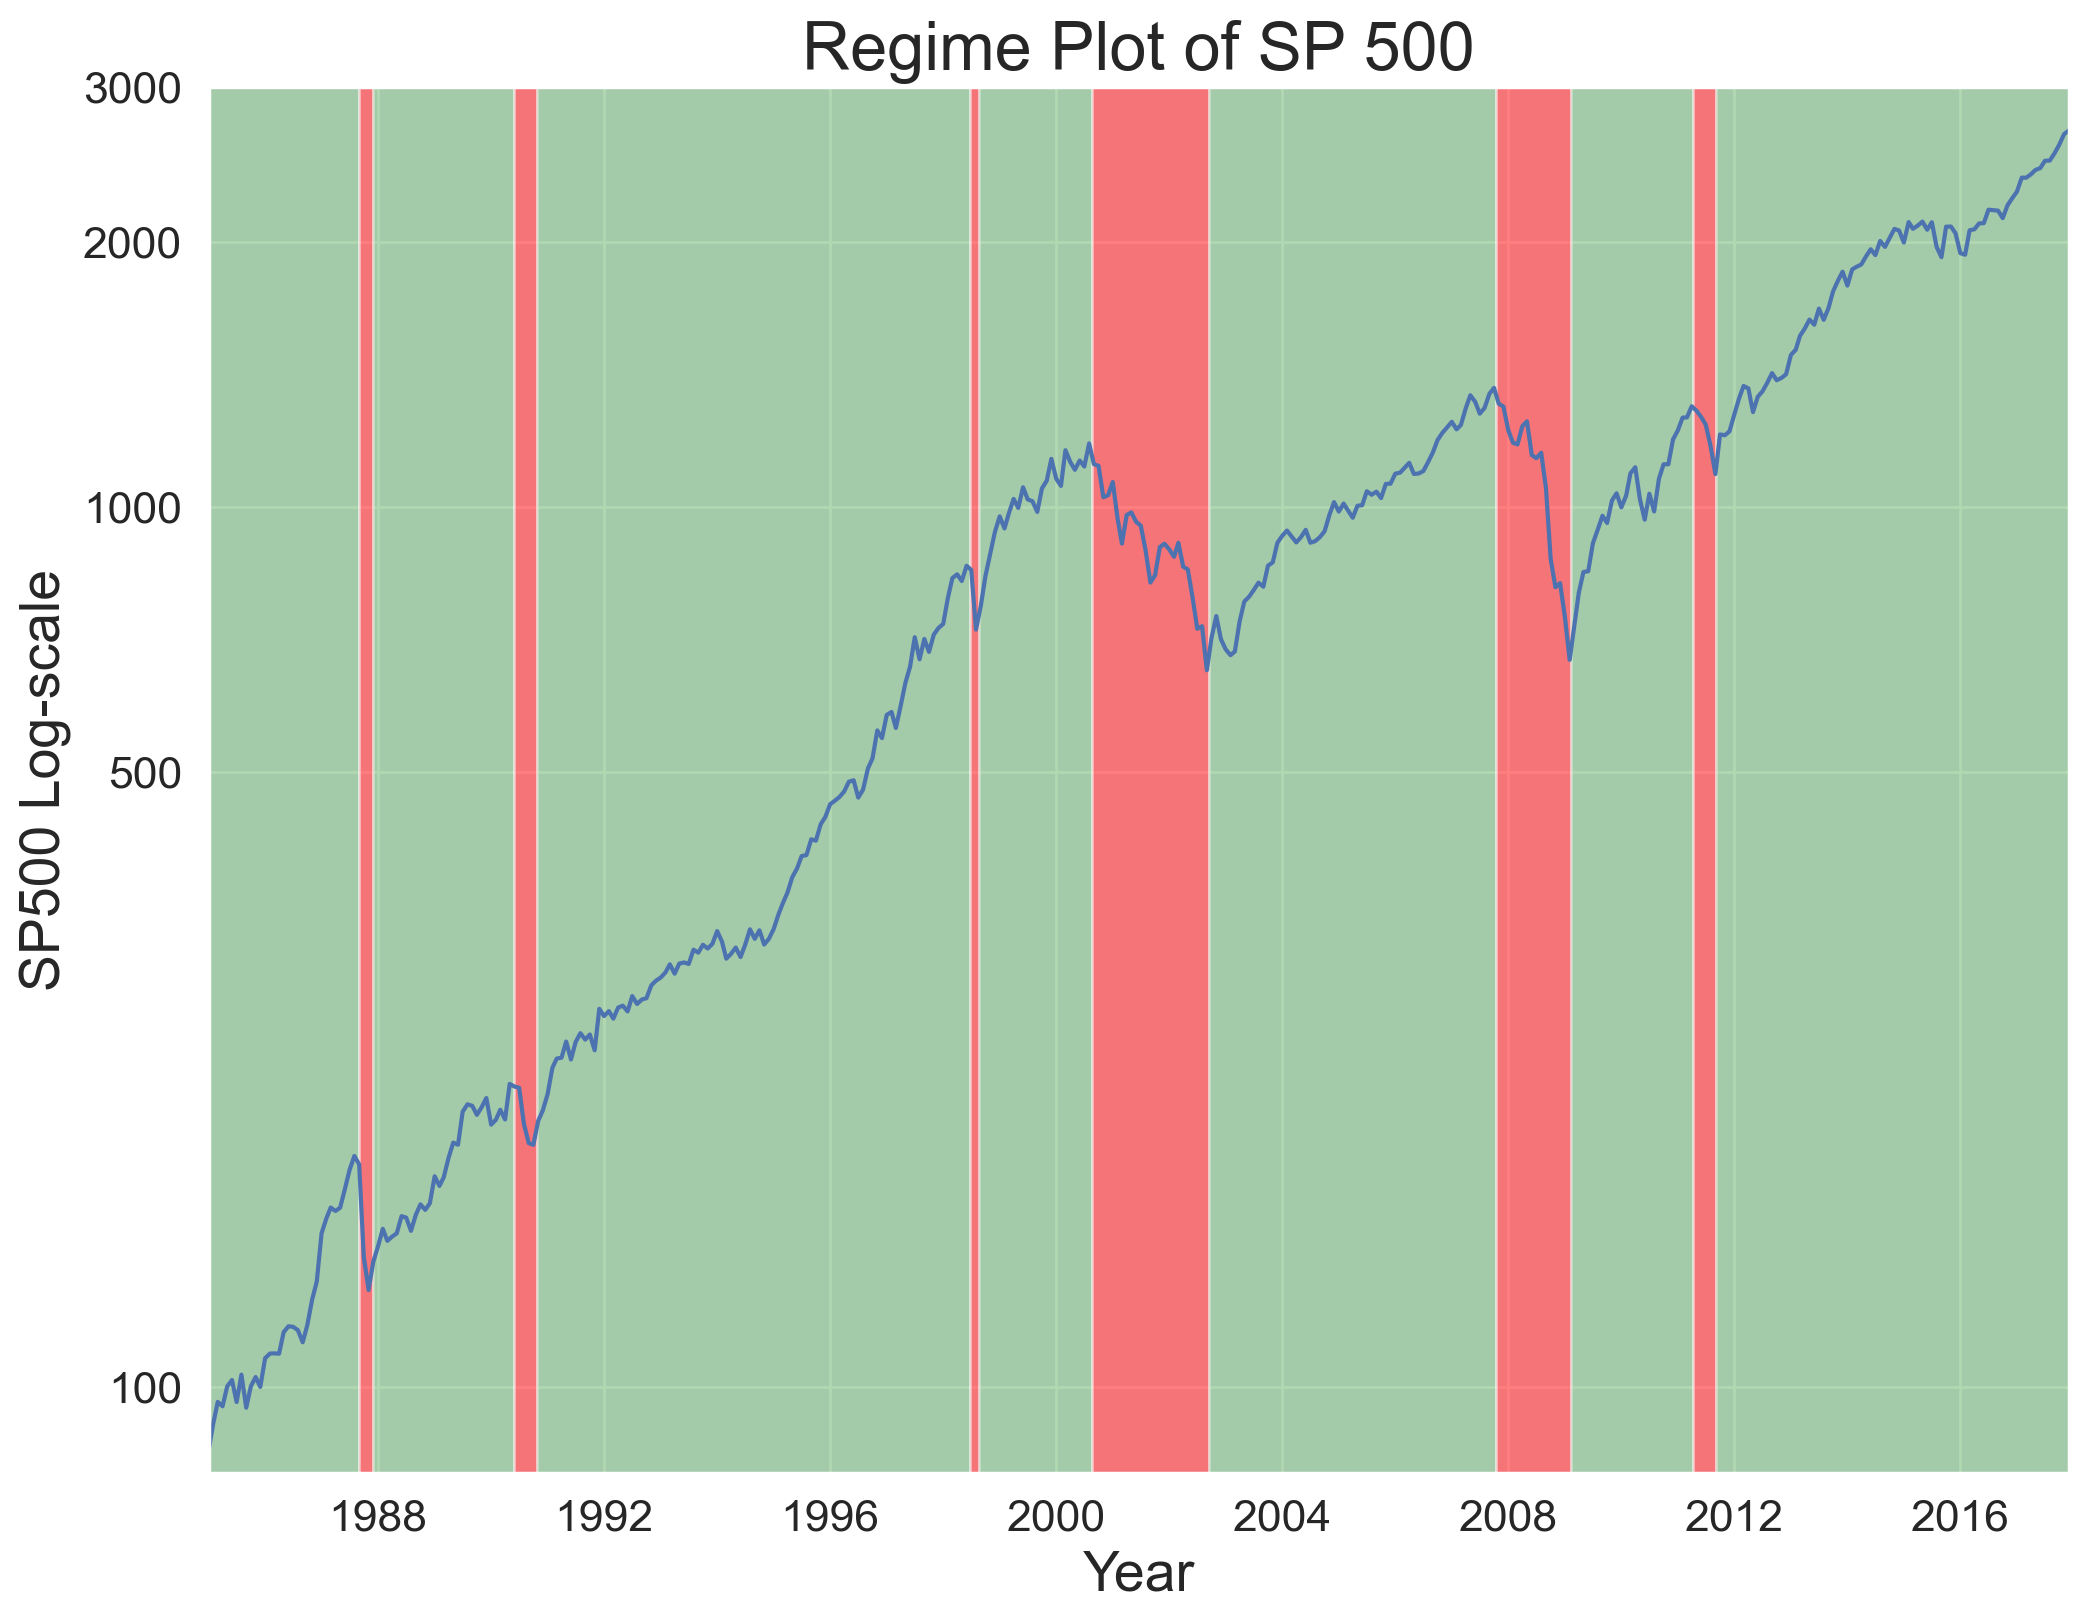

In [11]:
plot_regime_color(SP500_data, lambda_value=14)
# 6 crash periods

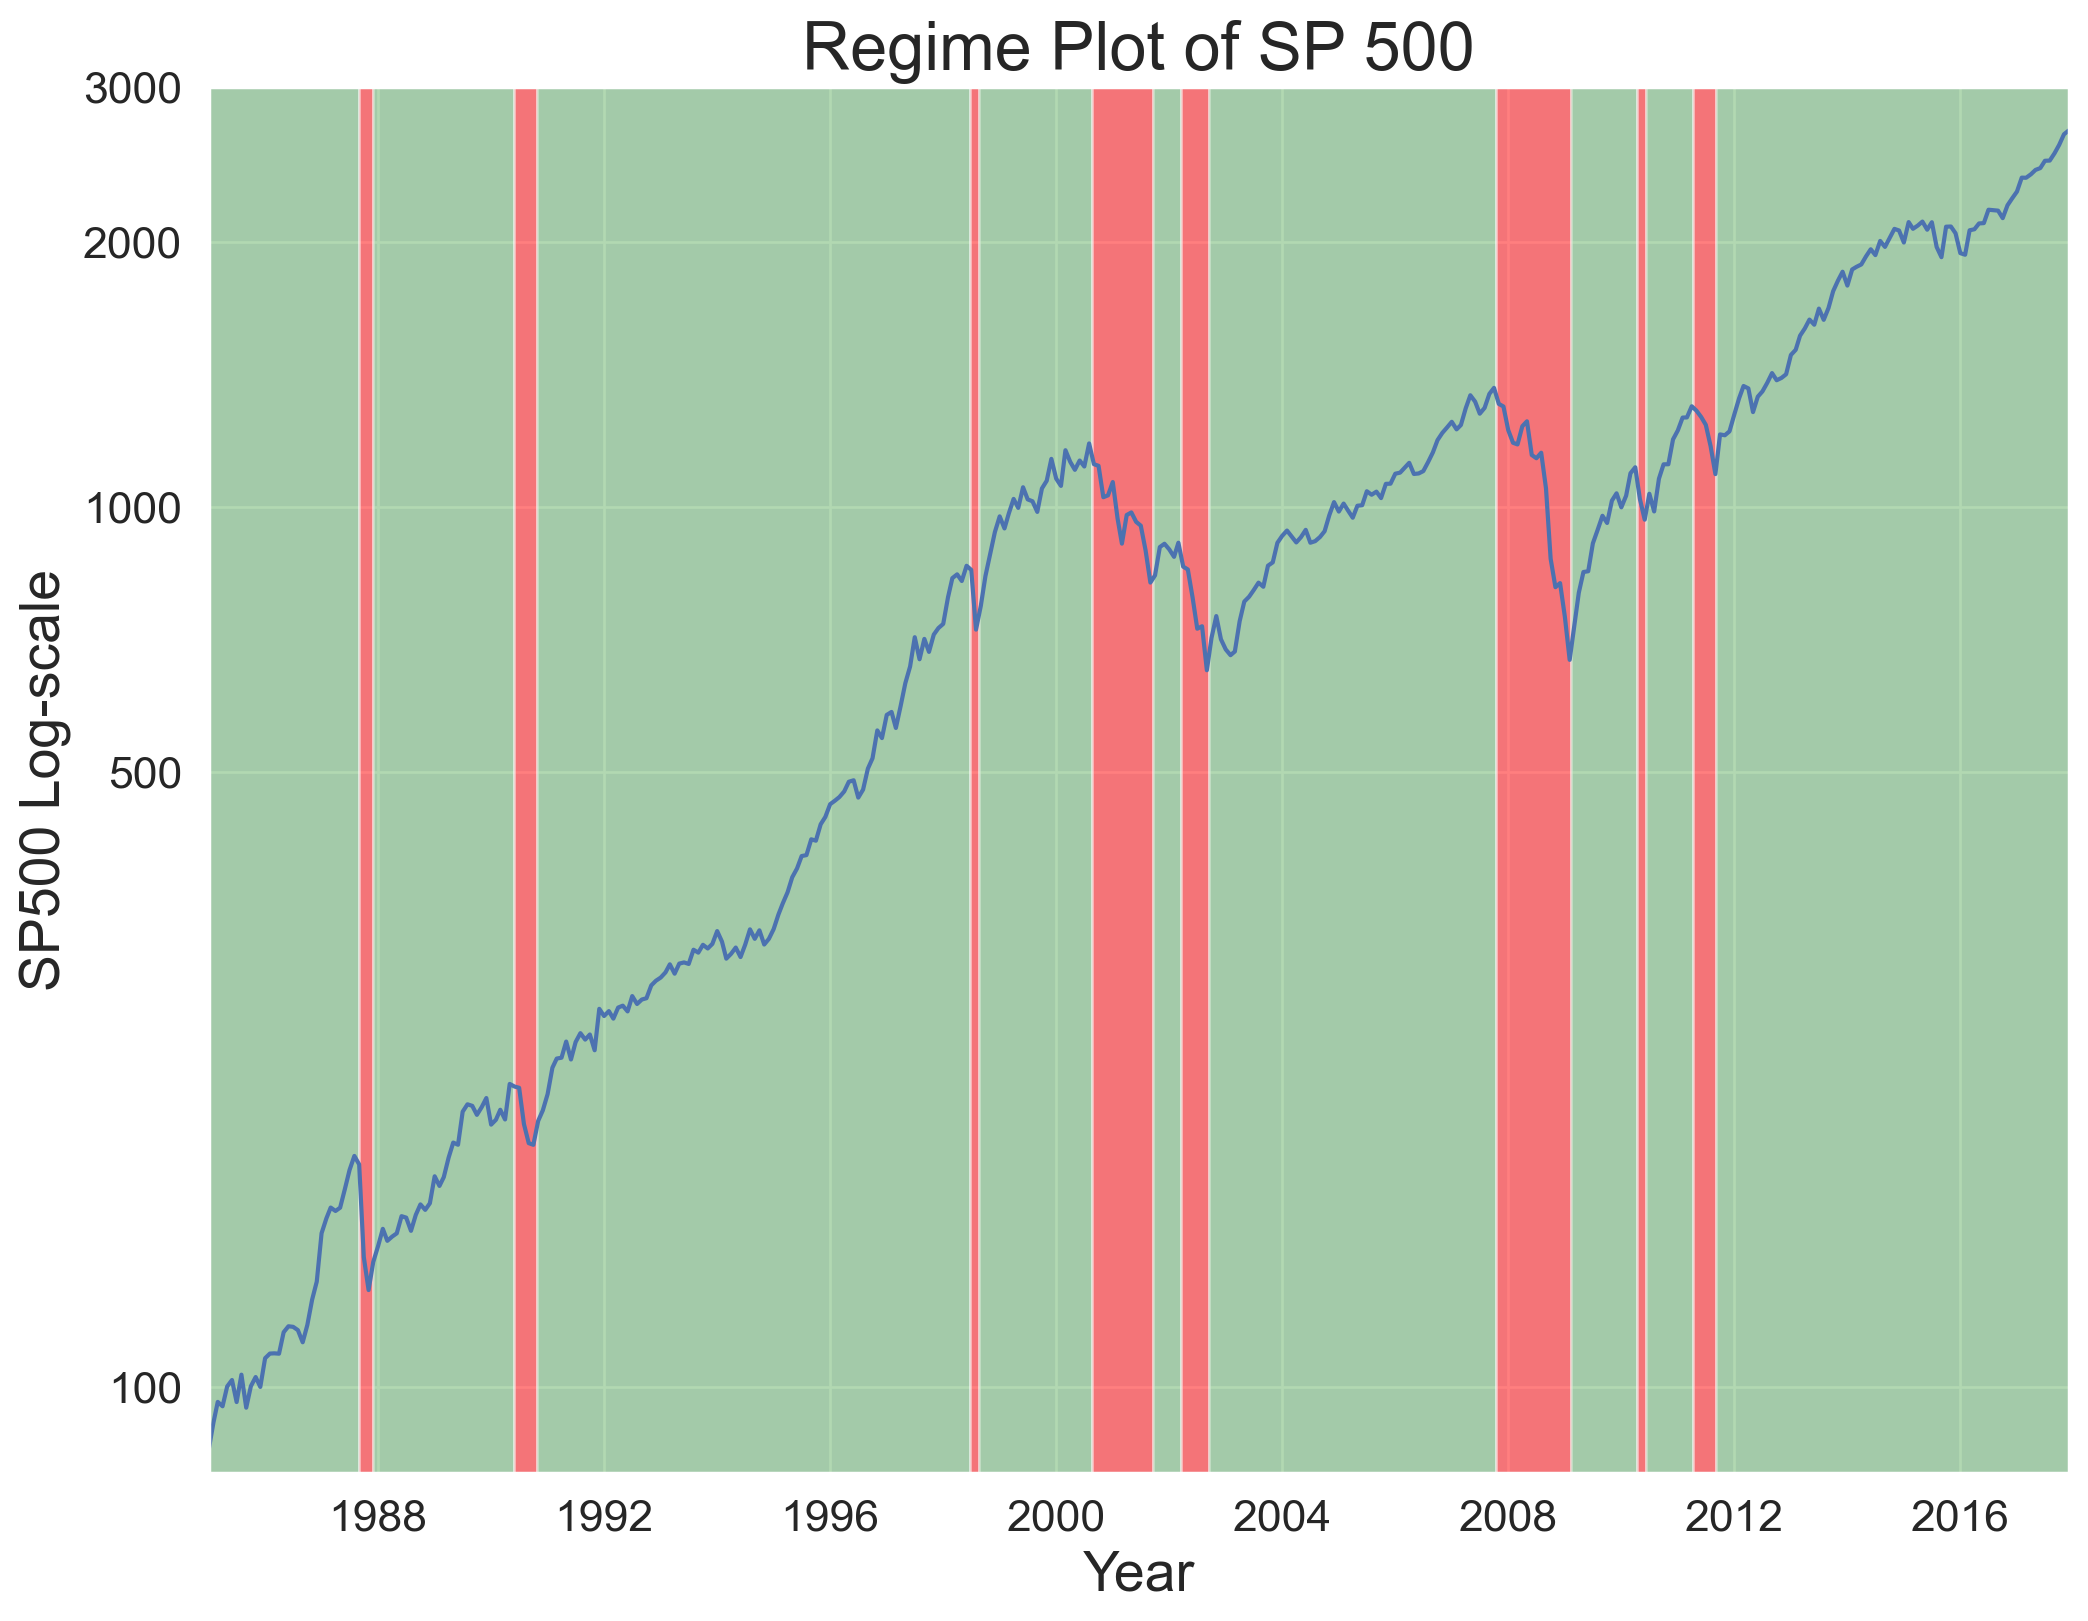

In [12]:
plot_regime_color(SP500_data, lambda_value=10)
# 8 crash periods

## 3. A Regime-based Single Period Model <a class="anchor" id="3"></a>
Here we will deal with the simplest model: we have stocks, bonds and cash.

### 3.1 Regime Identification with the Trend-Filtering Algorithm <a class="anchor" id="3.1"></a>

We have done trend-filtering algorithm in the previous section. Now let's just take the regime from the dataset (column "Regime-5").

### 3.2 Parameter Estimation and Simulation <a class="anchor" id="3.2"></a>



In [19]:
# Set Parameters
n_scen = 10000
m_freq = 12
# Range of expected returns
r_bar = np.arange(0.035,0.115,0.005) 

In [20]:
Q_all = np.cov(ret.T) * m_freq
r_annual = (1+geo_return(ret)) ** m_freq - 1
r_annual = r_annual.reshape(-1,1)

r_1 = (1+geo_return(ret)) ** m_freq - 1
r_g = (1+geo_return(ret_g)) ** m_freq - 1
r_c = (1+geo_return(ret_c)) ** m_freq - 1
n_g = int(n_scen*ret_g.shape[0] / ret.shape[0])
Q_g = np.cov(ret_g.T) * m_freq
Q_c = np.cov(ret_c.T) * m_freq

In [21]:
# Scenario Equivalent version
r_all_1 = np.random.multivariate_normal(r_1, Q_all, n_scen)

### 3.3 Single-period Portfolio Model <a class="anchor" id="3.3"></a>


c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning

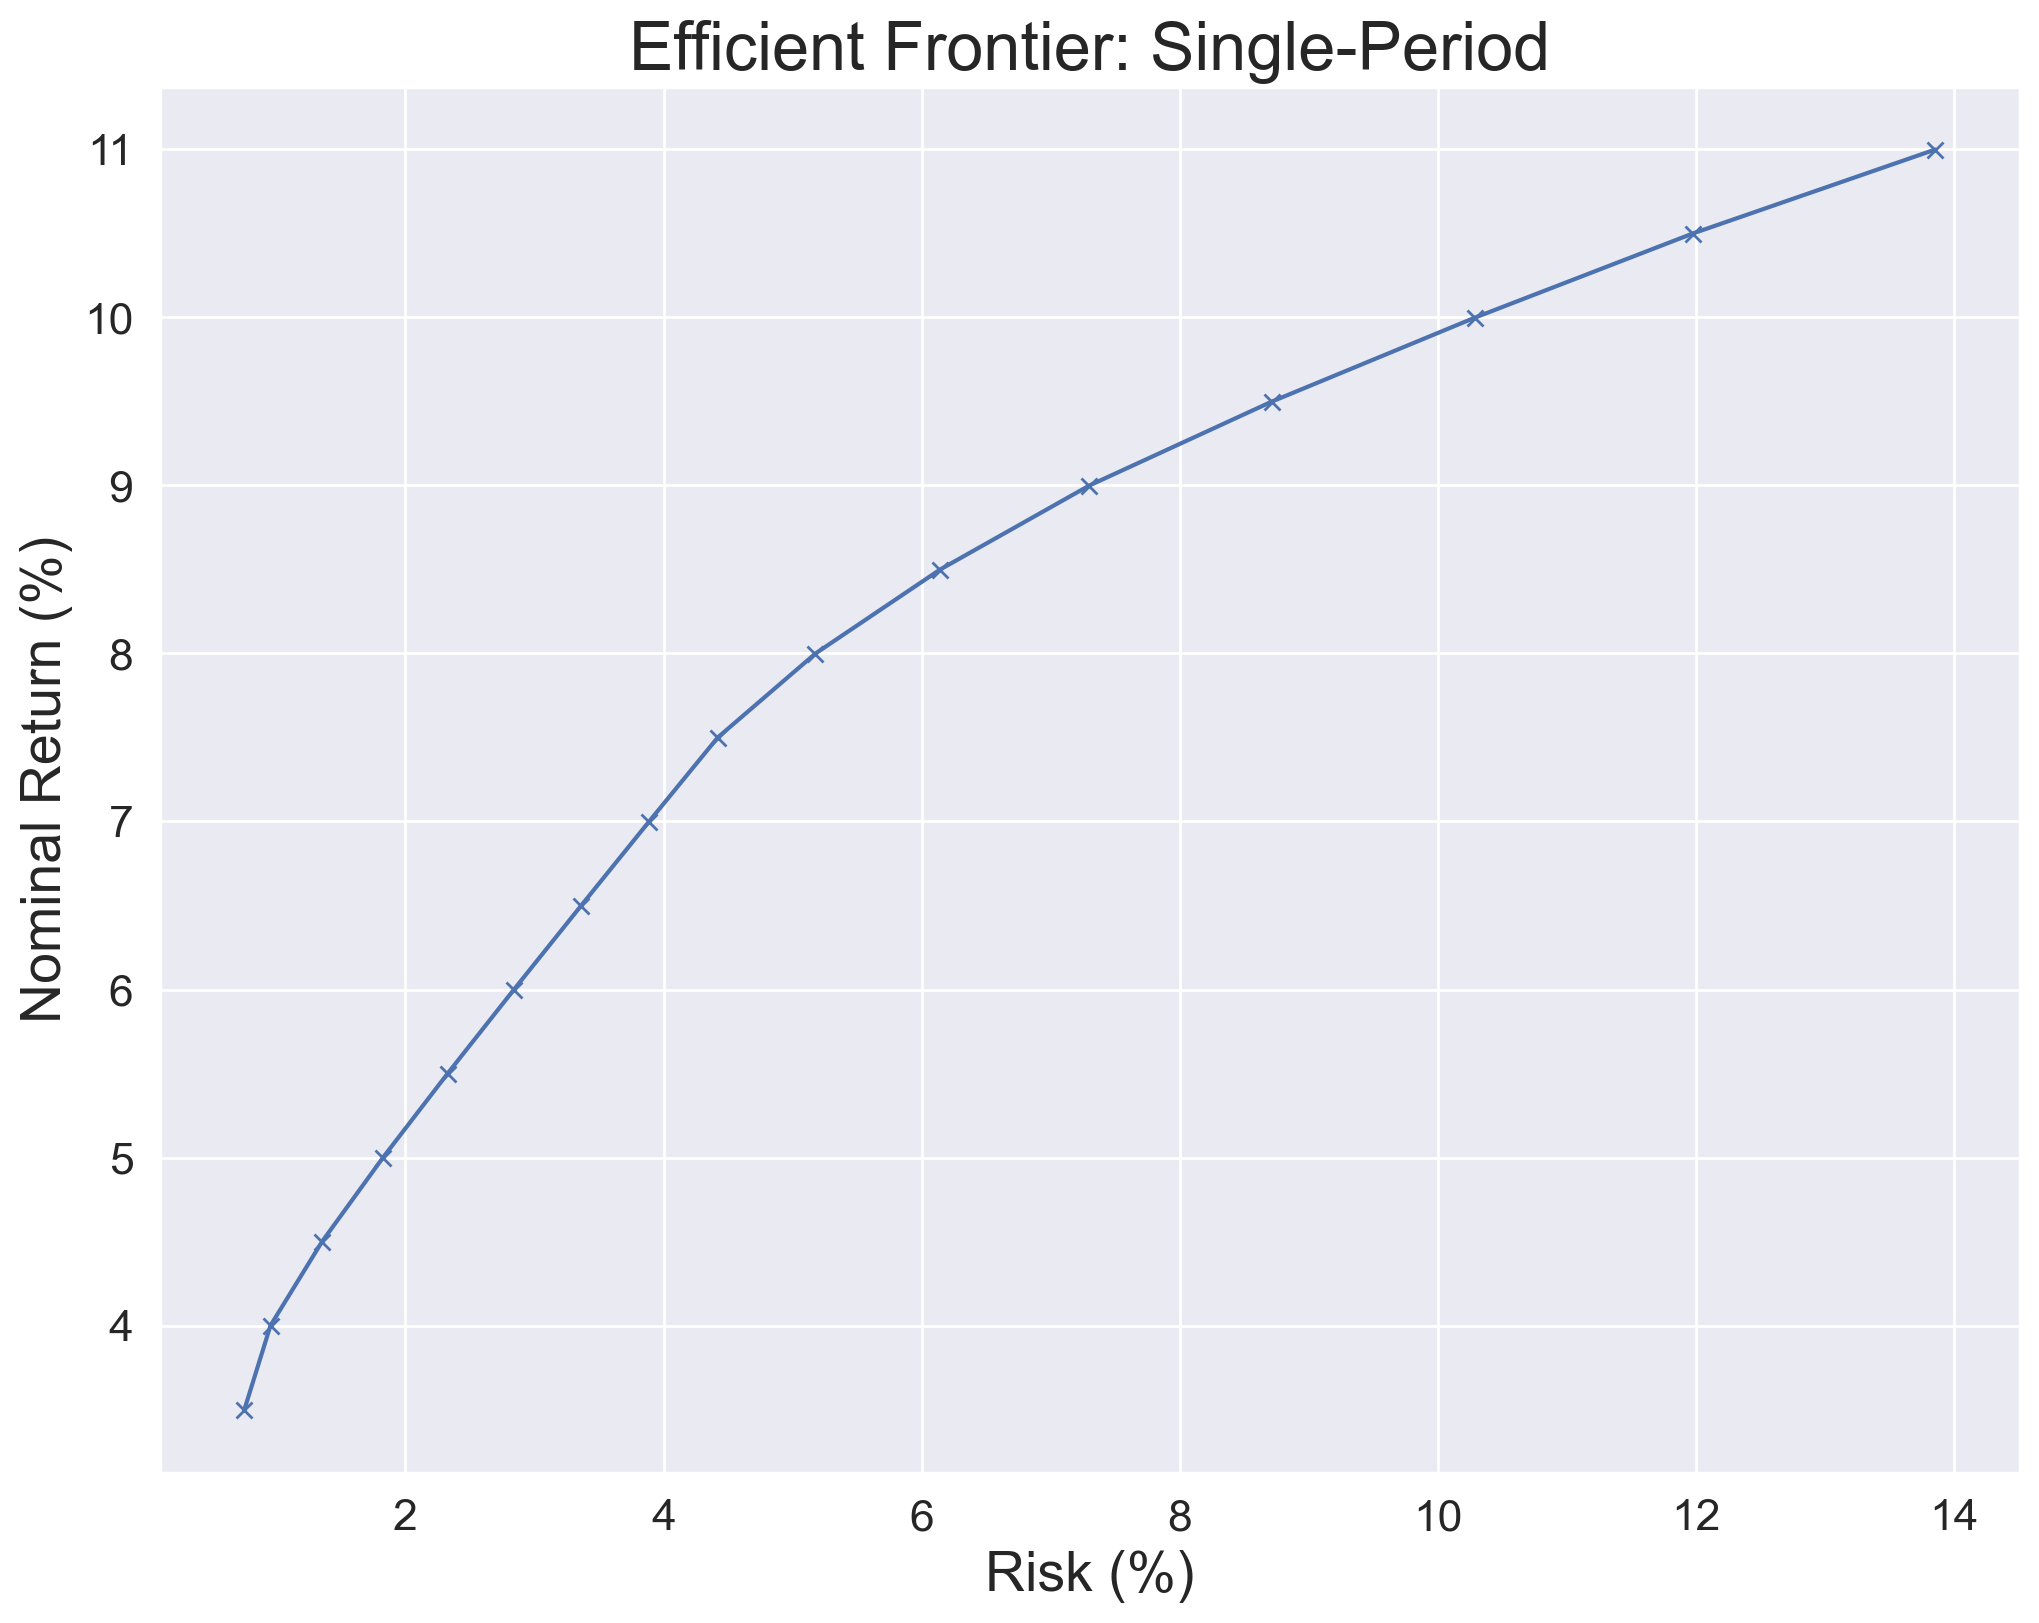

In [16]:
efficient_frontier_traditional(r_annual, Q_all, r_bar)

c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, UserWarning)
c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarni

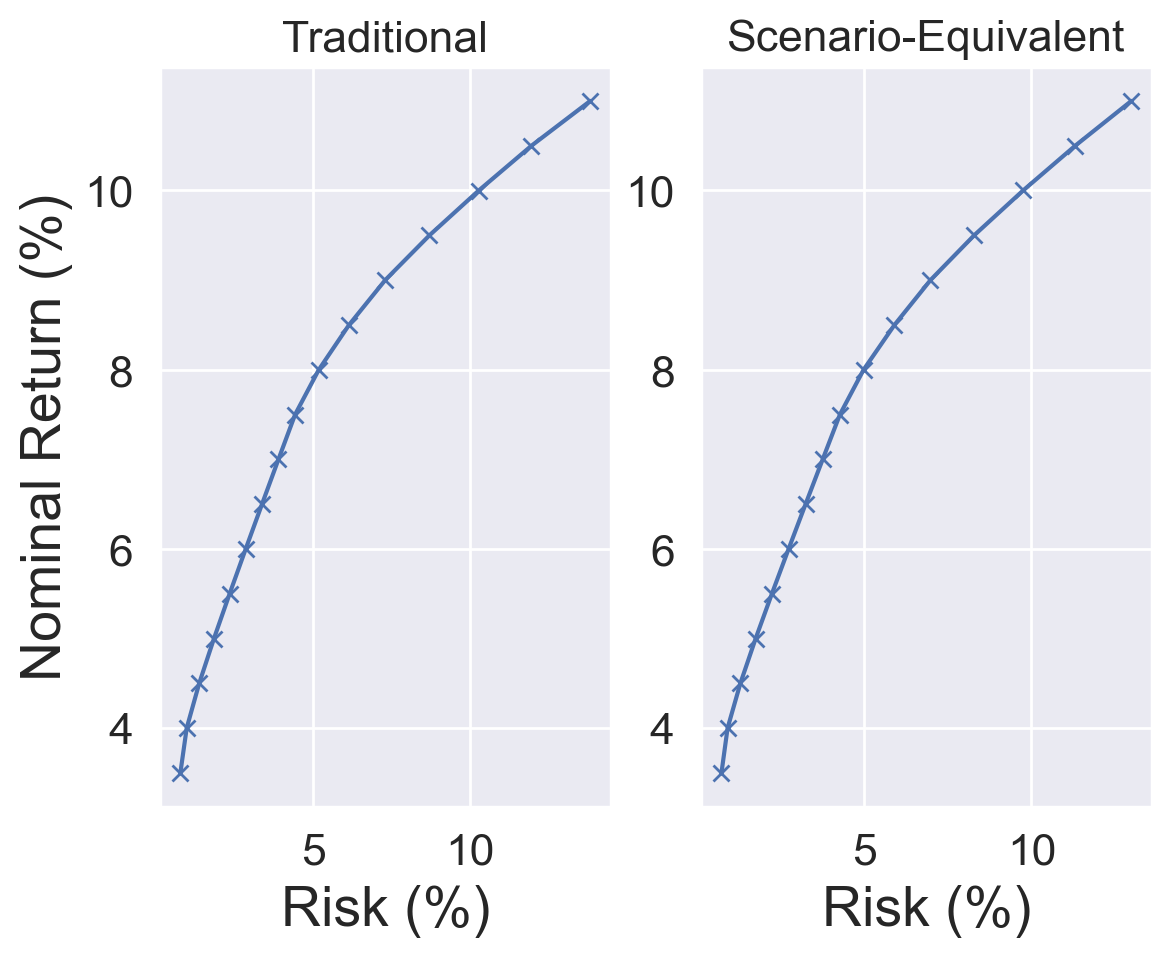

In [17]:
# Compare with scenario equivalent
efficient_frontier_comparison(r_annual, Q_all, r_bar)

### 3.4 Two-regime Simulation

c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 49 times so far.

  warnings.warn(msg, UserWarning)
c:\Users\Jason\anaconda3\envs\quant\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 50 times so far.

  warnings.warn(msg, UserWarni

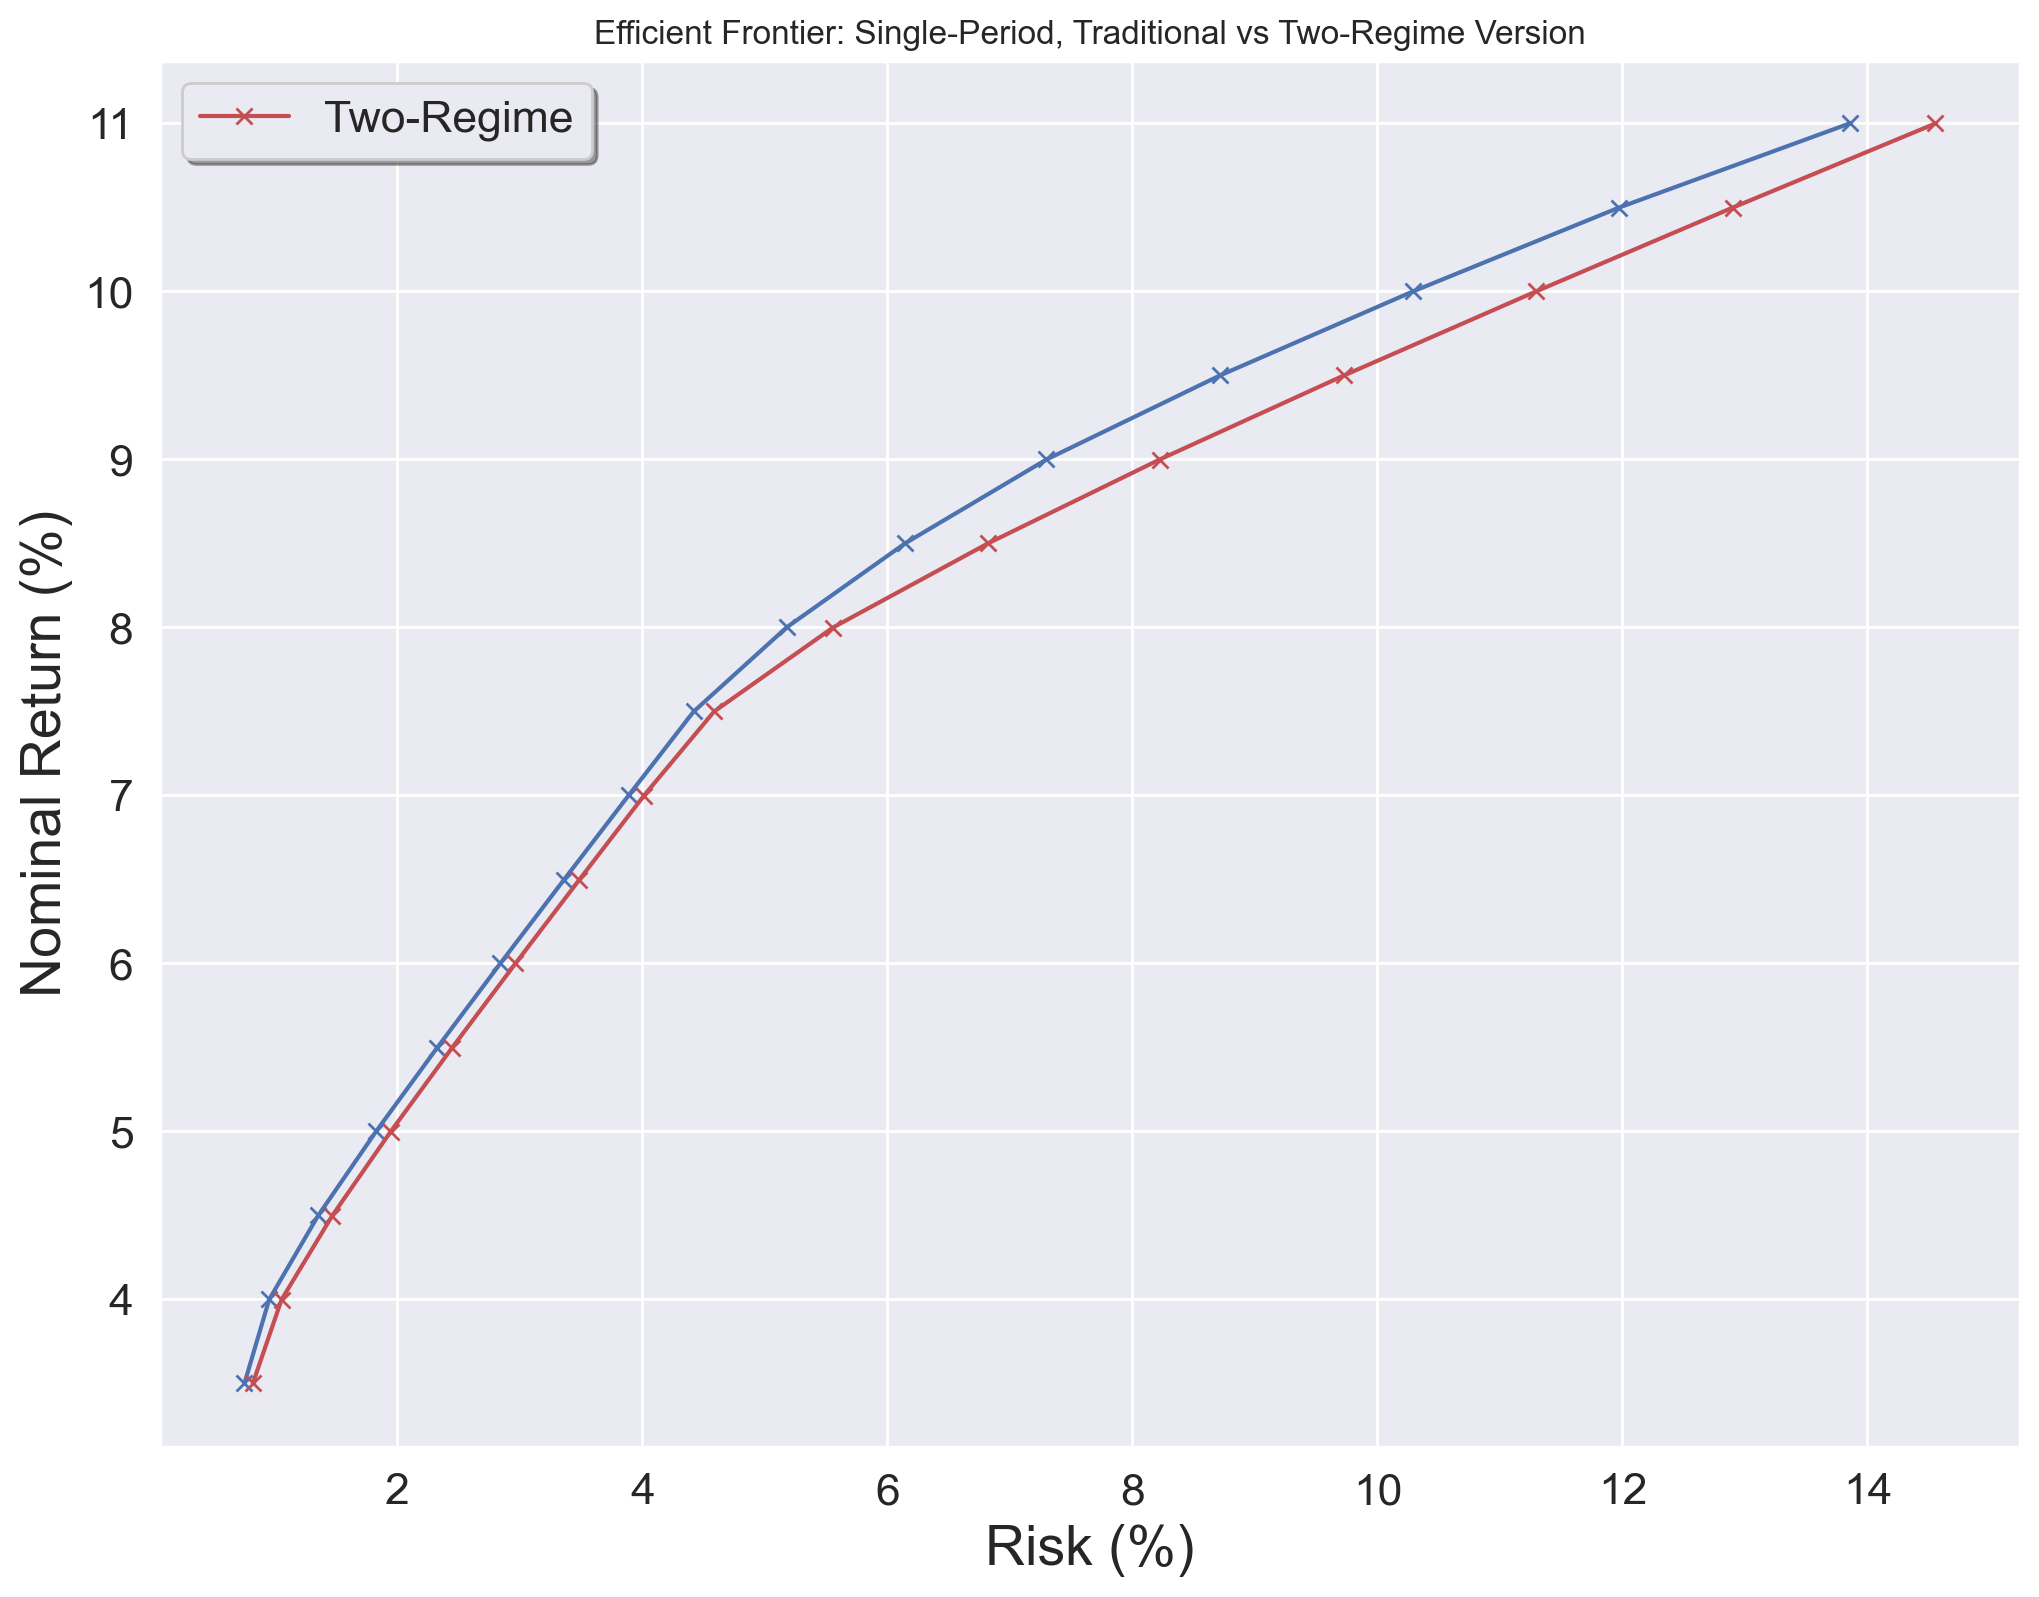

In [18]:
r_all_2 = efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar)

## 4. Application: Scenario-based Analysis of University Endowment <a class="anchor" id="3"></a>

In [22]:
r_all_50 = asset_simulation(asset_data, asset_num=8,regime_name='Regime-5',random_seed=7,n_scenarios=n_scen)
np.mean(np.mean(r_all_50,axis=0),axis=1)

array([1.00924363, 1.00731724, 1.00513161, 1.00718049, 1.00747885,
       1.0033481 , 1.0060505 , 1.00281213])

In [23]:
holdings = np.array([.3, 0, .2, .2, .1, 0, .15, .05])
result_temp = fund_simulation(holdings, r_all_50, spending_rate=0.07)

In [24]:
# Median Capital after 50 years
np.median(result_temp[:,-1])

1.941123610291247